<a href="https://colab.research.google.com/github/arturadib/agility/blob/master/Explorer_COVID_Dx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
if 'LOG_EXPERIMENT' not in globals():
  print('Log experiment? [y/N]')
  LOG_EXPERIMENT = True if input().lower()=='y' else False
else:
  LOG_EXPERIMENT = False

Log experiment? [y/N]



In [0]:
from google.colab import auth
auth.authenticate_user()

CONFIG_BASE_PATH = '/content/drive/Shared drives/Biocogniv-AI/Notebooks/Artur'
CONFIG_DATA_SRC = {
  'UVMMC':        'main-259821:ai_covid.uvmmc_04162020_1',
  'Cedars-Sinai': 'main-259821:ai_covid.cedars_04172020_1',
  'Maimonides':   'main-259821:ai_covid.maimonides_04162020_1',
  'BIDMC':        'main-259821:ai_covid.bidmc_04172020_1',
  'eICU':         'main-259821:ai_covid.eicu_04172020_1'
}

# Initialization and functions

### Imports

In [0]:
import pandas_gbq as pd_gbq
from packaging import version

# Need latest pandas_gbq for speed (supports option use_bqstorage_api)
if version.parse(pd_gbq.__version__) < version.parse('0.13.1'):
  !pip install --upgrade --quiet google-cloud-bigquery-storage # for read_gbq() etc
  !pip install --upgrade --quiet fastavro # for read_gbq() etc
  !pip install --upgrade --quiet pyarrow # for read_gbq() etc
  !pip install --upgrade --quiet pandas_gbq

  # Sneaking Comet in here as it needs a reboot too
  !pip install --upgrade --quiet comet_ml

  # Other upgrades
  !pip install --upgrade --quiet tqdm

  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

from tqdm.auto import tqdm
tqdm.pandas()

In [0]:
# If we get to this point, Comet is properly installed (i.e. kernel already restarted)
from comet_ml import Experiment

# Only log experiment after a fresh kernel restart (so code logging doesn't capture previous runs)
if ('exp' not in globals()) and LOG_EXPERIMENT:
  exp = Experiment(api_key="LDzOdwDSzcl6oMauFaguHreH4",
                  project_name="ai-covid", 
                  workspace="biocogniv")
  if len(exp.url)==0:
    raise Exception('Could not initialize experiment!')

In [5]:
%load_ext google.colab.data_table

import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import random
import math
from textwrap import wrap

import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

!pip install catboost
from catboost import CatBoostClassifier

!pip install lightgbm
from lightgbm import LGBMClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Go away evil SettingWithCopy warnings
pd.options.mode.chained_assignment = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Functions

In [0]:
def get_units(col):
  matches = re.findall(r'\((.+)\)$', col)
  if len(matches)==1:
    return matches[0]
  else:
    return ''

In [0]:
def human_readable_col(col):
  matches = re.findall(r'^(.+)__(.+)$', col)
  if len(matches)==1:
    name, units = matches[0]
    name = name.replace('_', ' ')
    units = units.replace('_', '/')
    units = units.replace('pct', '%')
    return f'{name} ({units})'
  else:
    return col

def human_readable_cols(df):
  col_dict = {old: human_readable_col(old) for old in df.columns}
  return df.rename(columns=col_dict)

In [0]:
def plot_fillrate(df):
  if len(df.columns)>30:
    plt.figure(figsize=(15,2))
  else:
    plt.figure(figsize=(12,2))

  counts = (100*df.notna().sum(axis=0) / len(df)).round(2)
  # counts = counts.sort_values(ascending=False)
  ax = sns.barplot(x=counts.index, y=counts)
  plt.title(f'Feature fill rate (%)', fontsize=12)
  plt.xticks(rotation=90, fontsize=9)
  plt.ylim(0, 100)
  for p, cnt in zip(ax.patches, counts):
    ax.annotate(f'{cnt:.0f}', (p.get_x()+0.20, p.get_height()), fontsize=8)  

In [0]:
def plot_demo(df, ycol='y', title=None):
  fig = plt.figure(figsize=(10,2))

  gs = fig.add_gridspec(1,6)
  ax1 = fig.add_subplot(gs[0, 0])
  ax2 = fig.add_subplot(gs[0, 1:3])
  ax3 = fig.add_subplot(gs[0, 3:])

  # Age
  ax1.set_ylim(0,80)
  sns.barplot(x=ycol, y=COL.age, data=df, ax=ax1)
  
  # Sex
  ax2.set_ylim(0,1)
  df_freq = (df[COL.sex].groupby(df[ycol]).value_counts(normalize=True).rename('Freq').reset_index())
  sns.barplot(x=COL.sex, y='Freq', hue=ycol, data=df_freq, order=['M','F'], ci='sd', ax=ax2)
  ax2.legend_.remove()

  # Race
  df_freq = (df[COL.race].groupby(df[ycol]).value_counts(normalize=True).rename('Freq').reset_index())
  if len(df_freq)>0:
    ax3.set_ylim(0,1)
    sns.barplot(x=COL.race, y='Freq', hue=ycol, data=df_freq, order=['W','H','B','A','O'], ax=ax3)

  if title!=None:
    plt.suptitle(title, y=1.02)
  plt.tight_layout()

In [0]:
def plot_sources(df, ycol='y'):
  fig = plt.figure(figsize=(12,2))

  gs = fig.add_gridspec(1,6)
  ax1 = fig.add_subplot(gs[0, 1])
  ax2 = fig.add_subplot(gs[0, 2:])

  counts = [(df[ycol]==0).sum(), (df[ycol]==1).sum()]
  ax1.set_title(f'Counts', fontsize=12)
  ax1.set_yscale('log')
  ax1.set_ylabel('')
  sns.barplot(x=['(-)', '(+)'], y=counts, ax=ax1)
  for p, cnt in zip(ax1.patches, counts):
    ax1.annotate(f'{cnt:,}', (p.get_x()+0.05, p.get_height()))

  counts = df['Source'].value_counts()
  ax2.set_yscale('log')
  sns.barplot(x=counts.index, y=counts, ax=ax2)
  for p, cnt in zip(ax2.patches, counts):
    ax2.annotate(f'{cnt:,}', (p.get_x()+0.20, p.get_height()), fontsize=12)
  plt.tight_layout()

In [0]:
def get_sirs_score(df):
  sirs_score =  (df[COL.temp]>100.4).astype(int) + (df[COL.temp]<96.8).astype(int) + \
                (df[COL.pulse]>90).astype(int) + (df[COL.respr]>20).astype(int) + \
                (df[COL.wbc]>12).astype(int) + (df[COL.wbc]<4).astype(int)
  return sirs_score

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_marker_roc(name, scores, y, line=False, silent=False):
  if silent:
    return    
  fpr, tpr, thresh = roc_curve(y, scores)
  auc = roc_auc_score(y, scores)
  if auc<0.5:
    _tpr = tpr
    tpr = fpr
    fpr = _tpr
    auc = 1 - auc

  if line:
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
  plt.plot(fpr, tpr, label=name + " (AUC=%0.2f)" % auc)
  plt.legend(loc="lower right")

In [0]:
from scipy import interp
from sklearn import metrics

def plot_roc(fpr_tprs, title, name, color_num=0):
    colors = ['b', 'g', 'k', 'y', 'c']
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []
    tprs = []

    for fpr, tpr, _ in fpr_tprs:
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)

    # Rest of ROC plot
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=colors[color_num],
             label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, 2*std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    title = "\n".join(wrap(f'ROC for {title}', 60))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")

In [0]:
from scipy import interp
from sklearn import metrics

def plot_roc_scores(fpr_tprs, title, units=None, color_num=1):
  # find min/max scores
  min_score = 1e12
  max_score = -1e12
  for fpr, tpr, thresh in fpr_tprs:
    max_score = np.amax(thresh[1:]) if np.amax(thresh[1:])>max_score else max_score
    min_score = np.amin(thresh[1:]) if np.amin(thresh[1:])<min_score else min_score

  p = np.linspace(min_score, max_score, 100)
  sens = []
  spec = []
  for fpr, tpr, thresh in fpr_tprs:
    sens.append(np.interp(p, thresh[1:][::-1], tpr[1:][::-1]))
    spec.append(np.interp(p, thresh[1:][::-1], (1-fpr[1:][::-1])))

  mean_sens = np.mean(sens, axis=0)
  mean_spec = np.mean(spec, axis=0)
  std_sens = np.std(sens, axis=0)
  std_spec = np.std(spec, axis=0)

  sens_upper = np.minimum(mean_sens + std_sens, 1)
  sens_lower = np.maximum(mean_sens - std_sens, 0)
  spec_upper = np.minimum(mean_spec + std_spec, 1)
  spec_lower = np.maximum(mean_spec - std_spec, 0)

  plt.fill_between(100*p, sens_lower, sens_upper, color='grey', alpha=.2)
  plt.fill_between(100*p, spec_lower, spec_upper, color='grey', alpha=.2)

  plt.plot(100*p, mean_sens, label='Sensitivity', color='orange')
  plt.plot(100*p, mean_spec, label='Specificity', color='b')

  plt.title("\n".join(wrap(title, 60)))
  plt.xlabel('Score cutoff' if units==None else f'Cutoff ({units})')
  plt.ylabel('')
  plt.legend(loc="upper left")

In [0]:
from scipy import interp
from sklearn import metrics

def plot_prc(prec_recalls, title, color_num=1):
    colors = ['b', 'g', 'r', 'k', 'y', 'c']
    mean_recall = np.linspace(0, 1, 100)
    aucs = []
    precs = []

    for prec, recall, _ in prec_recalls:
        recall = np.flip(recall)
        prec = np.flip(prec)
        precs.append(np.interp(mean_recall, recall, prec))
        precs[-1][0] = 1.0
        auc = metrics.auc(recall, prec)
        aucs.append(auc)

    mean_prec = np.mean(precs, axis=0)
    mean_prec[-1] = 0.0
    mean_auc = metrics.auc(mean_recall, mean_prec)
    std_auc = np.std(aucs)
    plt.plot(mean_recall, mean_prec, color=colors[color_num],
             label=r'AUC = %0.2f $\pm$ %0.2f' % (mean_auc, 2*std_auc),
             lw=2, alpha=.8)

    std_prec = np.std(precs, axis=0)
    precs_upper = np.minimum(mean_prec + std_prec, 1)
    precs_lower = np.maximum(mean_prec - std_prec, 0)
    plt.fill_between(mean_recall, precs_lower, precs_upper, color='grey', alpha=.2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title("\n".join(wrap(title, 60)))
    plt.legend(loc="upper right")

In [0]:
from scipy import interp
from sklearn import metrics

def plot_prc_scores(prec_recalls, title, units=None, color_num=1):
  # find min/max scores
  min_score = 1e12
  max_score = -1e12
  for fpr, tpr, thresh in fpr_tprs:
    max_score = np.amax(thresh[1:]) if np.amax(thresh[1:])>max_score else max_score
    min_score = np.amin(thresh[1:]) if np.amin(thresh[1:])<min_score else min_score

  p = np.linspace(min_score, max_score, 100)
  precs = []
  recs = []
  for prec, rec, thresh in prec_recalls:
    precs.append(np.interp(p, thresh, prec[:-1]))
    recs.append(np.interp(p, thresh, rec[:-1]))

  mean_prec = np.mean(precs, axis=0)
  mean_rec = np.mean(recs, axis=0)
  std_prec = np.std(precs, axis=0)
  std_rec = np.std(recs, axis=0)

  prec_upper = np.minimum(mean_prec + std_prec, 1)
  prec_lower = np.maximum(mean_prec - std_prec, 0)
  rec_upper = np.minimum(mean_rec + std_rec, 1)
  rec_lower = np.maximum(mean_rec - std_rec, 0)

  plt.fill_between(100*p, prec_lower, prec_upper, color='grey', alpha=.2)
  plt.fill_between(100*p, rec_lower, rec_upper, color='grey', alpha=.2)

  plt.plot(100*p, mean_prec, label='PPV (Precision)', color='b')
  plt.plot(100*p, mean_rec, label='Sensitivity (Recall)', color='orange')

  plt.title("\n".join(wrap(title, 60)))
  plt.xlabel('Score cutoff' if units==None else f'Cutoff ({units})')
  plt.ylabel('')
  plt.legend(loc="upper left")

  return mean_prec, mean_rec, p

# Schema

In [0]:
# DATA_SCHEMA – Reuse this across codes to ensure schema consistency
import re

DATA_SCHEMA =  {'Age__yrs': 'Int64',
                'ALT__IU_L': 'float64',
                'Albumin__g_dL': 'float64',
                'ALP__IU_L': 'float64',
                'AST__IU_L': 'float64',
                'Atypical_Lymphocytes__pct': 'float64',
                'Bands__pct': 'float64',
                'Basophils__pct': 'float64',
                'Bicarbonate__mEq_L': 'float64',
                'Bilirubin_Total__mg_dL': 'float64',
                'BUN__mg_dL': 'float64',
                'CRP__mg_L': 'float64',
                'Calcium_Total__mg_dL': 'float64',
                'Chloride__mEq_L': 'float64',
                'Creatinine__mg_dL': 'float64',
                'DDimer__ng_mL': 'float64',
                'DiaBP__mmHg': 'float64',
                'ed_ccsrs': 'object',
                'ed_icds': 'object',
                'ed_icd10s': 'object',
                'Eosinophils__pct': 'float64',
                'Ferritin__ng_mL': 'float64',
                'Glucose__mg_dL': 'float64',
                'Hematocrit__pct': 'float64',
                'Hemoglobin__g_dL': 'float64',
                'hosp_ccsrs': 'object',
                'hosp_icds': 'object',
                'hosp_icd10s': 'object',
                'LDH__IU_L': 'float64',
                'Lactate__mmol_L': 'float64',
                'Lymphocytes__pct': 'float64',
                'MCHC__g_dL': 'float64',
                'MCH__pg': 'float64',
                'MCV__fL': 'float64',
                'Metamyelocytes__pct': 'float64',
                'Myelocytes__pct': 'float64',
                'Monocytes__pct': 'float64',
                'Neutrophils__pct': 'float64',
                'PTT__sec': 'float64',
                'PT__sec': 'float64',
                'Platelet_Count__K_uL': 'float64',
                'Potassium__mEq_L': 'float64',
                'Procalcitonin__ng_mL': 'float64',
                'Pulse__bpm': 'float64',
                'RDW__pct': 'float64',
                'Race': 'object',
                'RBC__m_uL': 'float64',
                'RespR__bpm': 'float64',
                'Sex': 'object',
                'Sodium__mEq_L': 'float64',
                'SpO2__pct': 'float64',
                'SysBP__mmHg': 'float64',
                'Temp__F': 'float64',
                'TroponinI__ng_mL': 'float64',
                'TroponinT__ng_mL': 'float64',
                'WBC__K_uL': 'float64',
                'hospdeath': 'Int64',
                'hosp_ccsrs': 'object',
                'hosp_icds': 'object',
                'hosp_icd10s': 'object',
                'icuadmit': 'Int64',
                'los': 'float64',
                'pCO2__mmHg': 'float64',
                'pH__units': 'float64',
                'pO2__mmHg': 'float64'}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

COL = dotdict()
for colname in DATA_SCHEMA:
  key = re.findall(r'^([^_]+)', colname)[0].lower() if '__' in colname else colname.lower()
  if key in COL:
    raise Exception(f'KEY CONFLICT! ({key}) CHOOSE A DIFFERENT NAME')
  COL[key] = colname

# Import data

### ICD codes dictionary

In [18]:
df_icd_codes = pd_gbq.read_gbq(f'SELECT * FROM `ai_covid.icd_titles_04162020_1`',
                               project_id='main-259821', 
                               use_bqstorage_api=True,
                               index_col='icd')
df_icd_codes

Downloading: 100%|██████████| 88408/88408 [00:02<00:00, 29548.40rows/s]


,short_title
icd,
436,Cva
L70,Acne
78001,Coma
E0062,Golf
M10,Gout
...,...
Y11,"Poisoning by and exposure to antiepileptic, se..."
X61,Intentional self-poisoning (suicide) by and ex...
Y56,"Adverse effects in therapeutic use, topical ag..."


### CCSR codes dictionary

In [19]:
df_ccsr_codes = pd_gbq.read_gbq(f'SELECT * FROM `ai_covid.ccsr_titles_04162020_1`',
                               project_id='main-259821', 
                               use_bqstorage_api=True,
                               index_col='ccsr')
df_ccsr_codes

Downloading: 100%|██████████| 539/539 [00:01<00:00, 305.83rows/s]


,title
ccsr,
BLD001,Nutritional anemia
BLD002,Hemolytic anemia
BLD003,Aplastic anemia
BLD004,Acute posthemorrhagic anemia
BLD005,Sickle cell trait/anemia
...,...
SYM013,Respiratory signs and symptoms
SYM014,Skin/Subcutaneous signs and symptoms
SYM015,General sensation/perception signs and symptoms


### Data tables

In [20]:
import os.path
import hashlib

src_hash = hashlib.md5(str(CONFIG_DATA_SRC).encode('utf8')).hexdigest()
filename = f'df_data_raw-{src_hash[:8]}.csv'

if os.path.isfile(filename):
  df_data_raw = pd.read_csv(filename, index_col='visit_id', dtype=DATA_SCHEMA)
else:
  WHITELIST = ['notes', 'days_symptoms', 'Temp__C', 'covid']

  df_data_raw = pd.DataFrame()
  flag = False
  for key, path in CONFIG_DATA_SRC.items():
    project, table = re.findall(r'(.+):(.+)', path)[0]
    df = pd_gbq.read_gbq(f'SELECT * FROM `{table}`', 
                        project_id=project, 
                        use_bqstorage_api=True,
                        index_col='visit_id')

    diff = set(df.columns).difference(set(DATA_SCHEMA))
    diff = diff.difference(set(WHITELIST))
    if len(diff)>0:
      print()
      print('=================================================================')
      print(f'WARNING: Schema mismatch for table {table}')
      print(f'  df_data - schema: {diff}')
      print('=================================================================')
      print()
      flag = True    

    if set(df[COL.sex].value_counts().index) > {'M', 'F'}:
      raise Exception(f'Unexpected Sex values:\n{df[COL.sex].value_counts()}')

    if set(df[COL.age].value_counts().index) > {0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100}:
      raise Exception(f'Unexpected Age values:\n{df[COL.age].value_counts()}')

    if set(df[COL.race].value_counts().index) > {'W', 'H', 'B', 'A', 'O'}:
      raise Exception(f'Unexpected Race values:\n{df[COL.race].value_counts()}')

    df['Source'] = key
    df.index = df.index.map(lambda x: f'{key}:{x}')

    df_data_raw = pd.concat([df_data_raw, df])

  if flag:
    raise Exception('Did not pass integrity checks. See above.')
  
  df_data_raw = df_data_raw.astype(dtype=DATA_SCHEMA)

  # Save before messing with column names
  df_data_raw.to_csv(filename)

#
# Common code to whereever the data came from:
#

# Duplicate check
if df_data_raw.index.duplicated().sum()>0:
  raise Exception('Duplicate index found!')

# Convert BigQuery column names into human-friendly names
for key in COL:
  COL[key] = human_readable_col(COL[key])
COL
df_data_raw = human_readable_cols(df_data_raw)

# Transforms
df_data_raw['covid'] = df_data_raw['covid'].fillna(0).astype('int')
df_data_raw[COL.age] = df_data_raw[COL.age].map(lambda x: int(x/10)*10 if np.isfinite(x) else None)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data stats

## Features

### All (float) features

In [21]:
#@title
df_feats = df_data_raw.select_dtypes(include=['float64'])
df = pd.DataFrame(df_feats.notna().sum().rename('count (notna)'))
df = df.join(df_feats.quantile(0.10).round(2).rename('bottom decile'))
df = df.join(df_feats.median().round(2).rename('median'))
df = df.join(df_feats.quantile(0.90).round(2).rename('top decile'))
df

,count (notna),bottom decile,median,top decile
RespR (bpm),299286,15.00,18.00,21.00
Pulse (bpm),299671,62.00,80.00,107.00
SysBP (mmHg),298125,105.00,130.00,161.00
DiaBP (mmHg),298147,57.00,75.00,95.00
Temp (C),73,36.22,37.30,38.48
SpO2 (%),283927,95.00,99.00,100.00
Temp (F),222116,97.30,98.10,99.10
Sodium (mEq/L),174164,132.00,138.00,143.00
Potassium (mEq/L),173777,3.50,4.20,5.30
Chloride (mEq/L),174069,94.00,102.00,107.00


### Fill rates by source

<IPython.core.display.Javascript object>

UVMMC


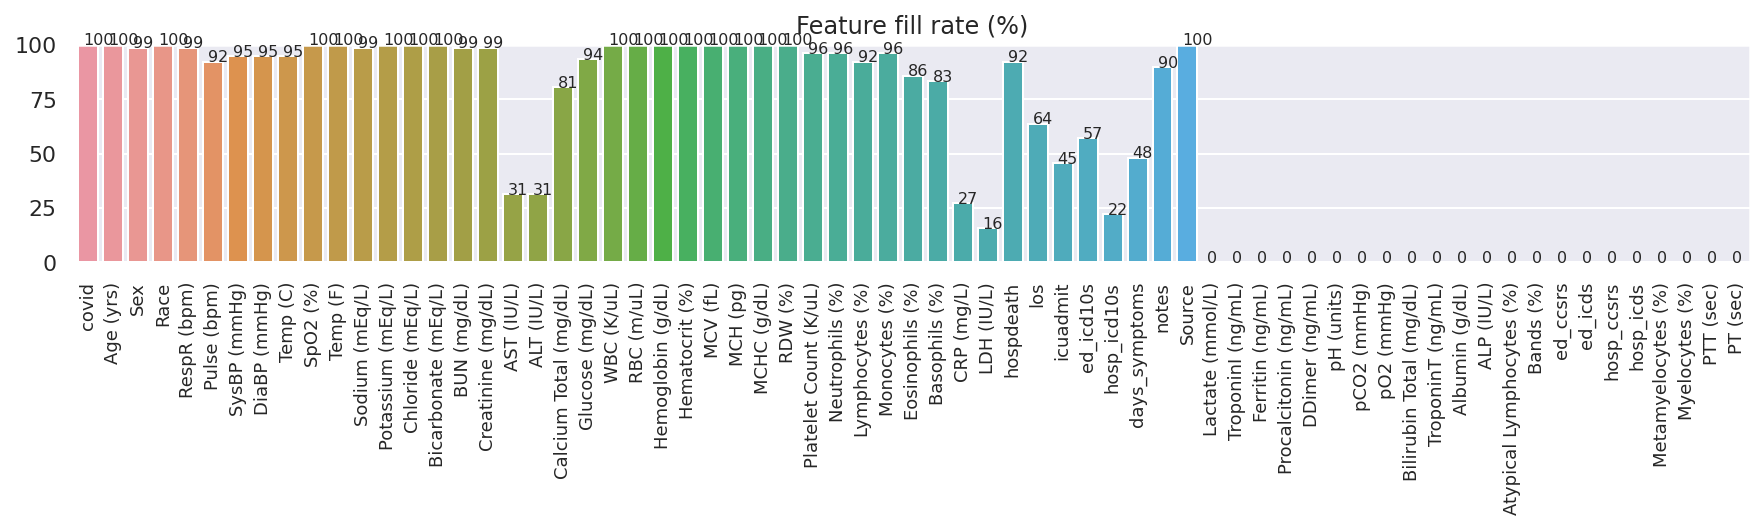

Cedars-Sinai


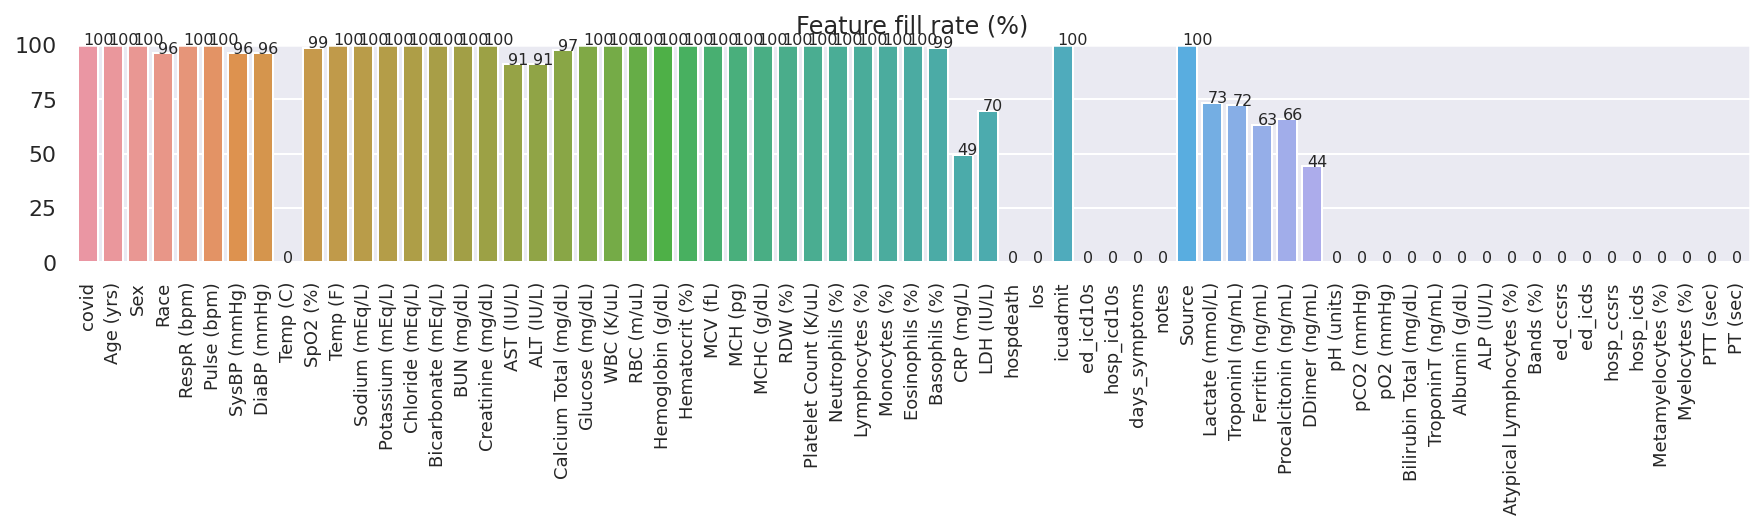

Maimonides


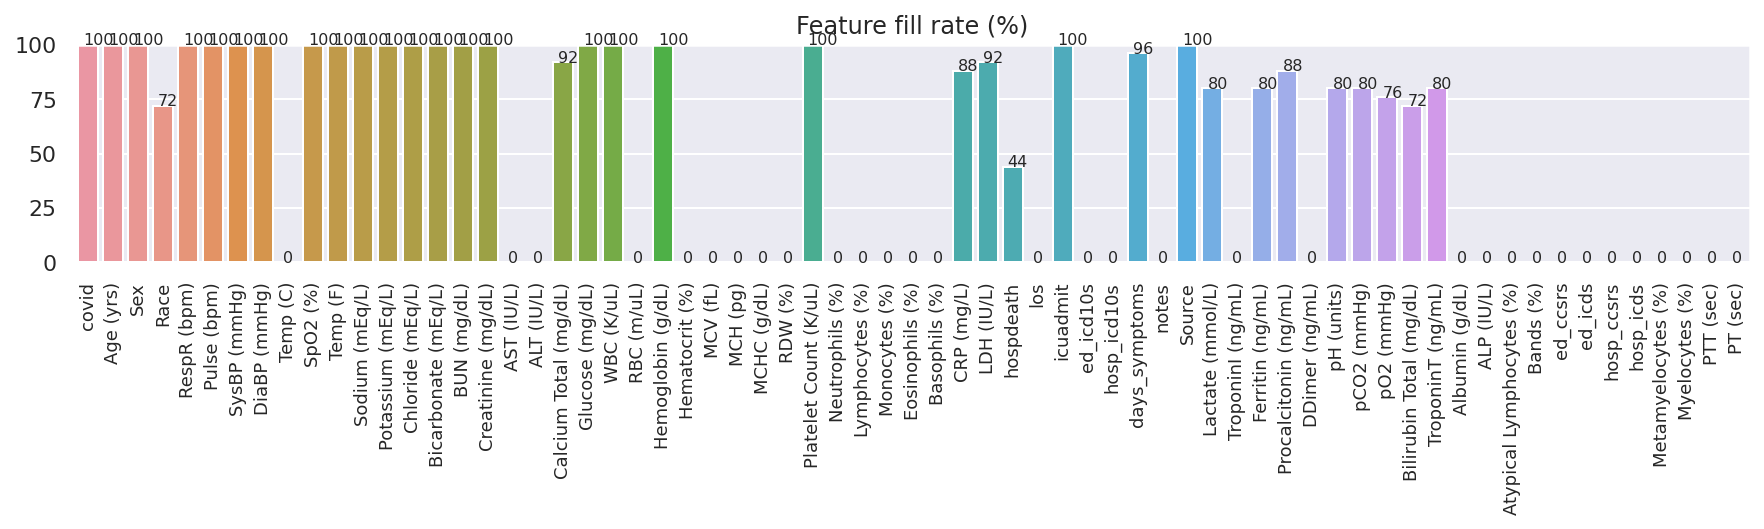

BIDMC


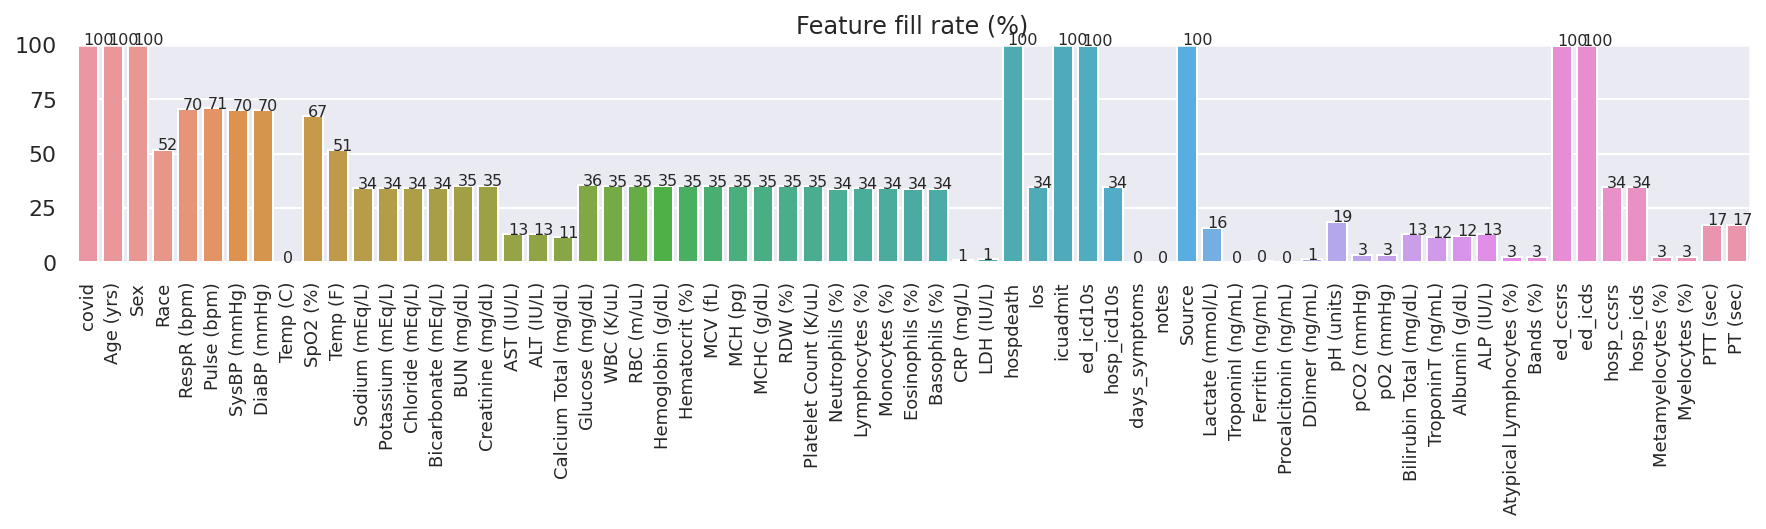

eICU


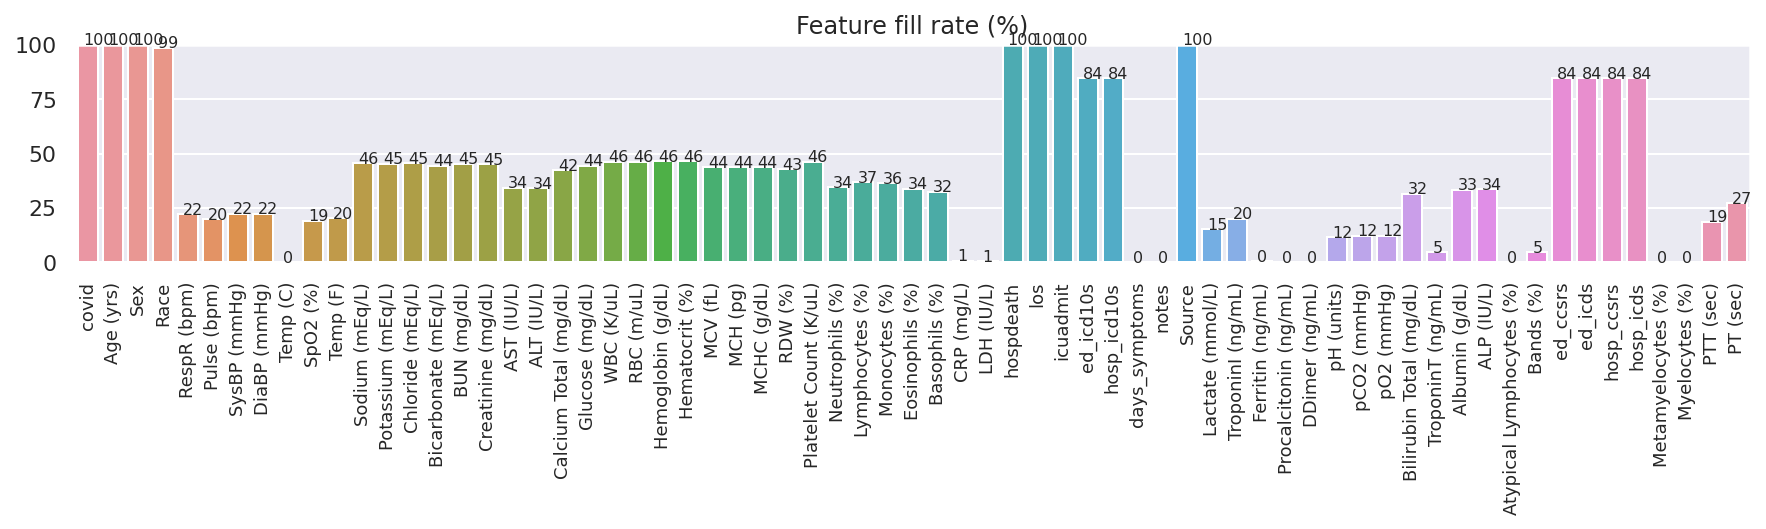

All


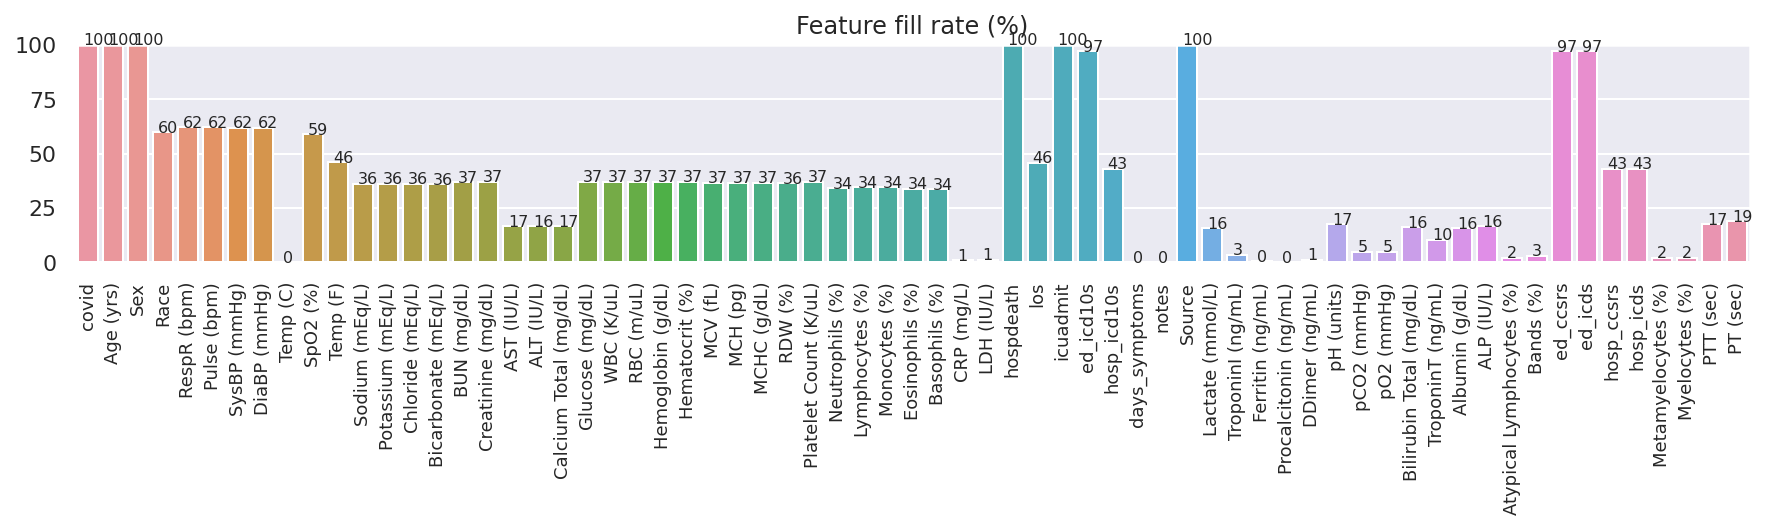

In [22]:
#@title

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

for src in CONFIG_DATA_SRC:
  print(src)
  plot_fillrate(df_data_raw[df_data_raw['Source']==src])
  plt.show()

print('All')
plot_fillrate(df_data_raw)

## Demographics

<IPython.core.display.Javascript object>

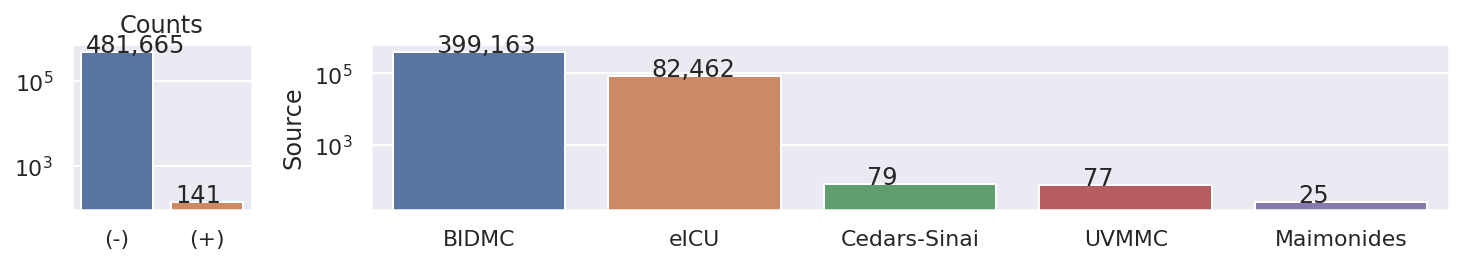

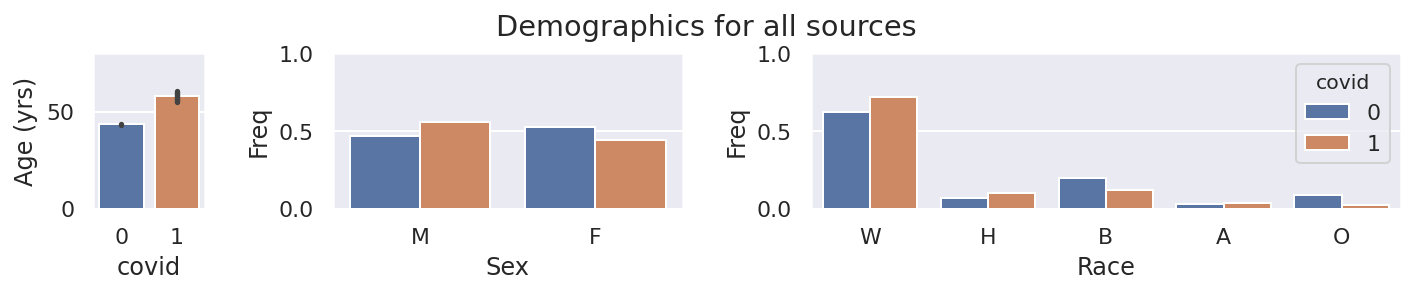

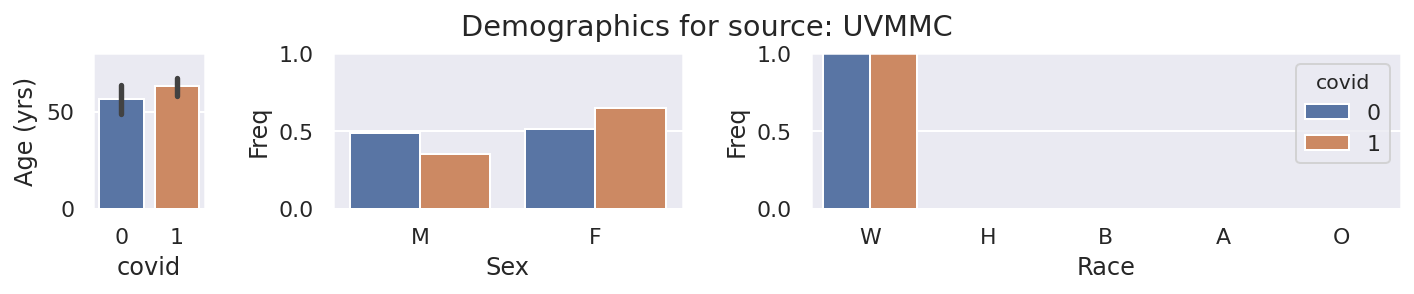

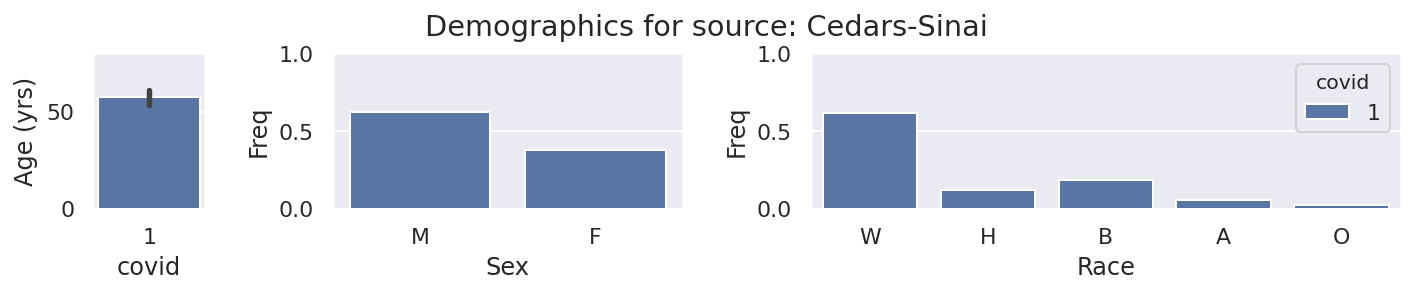

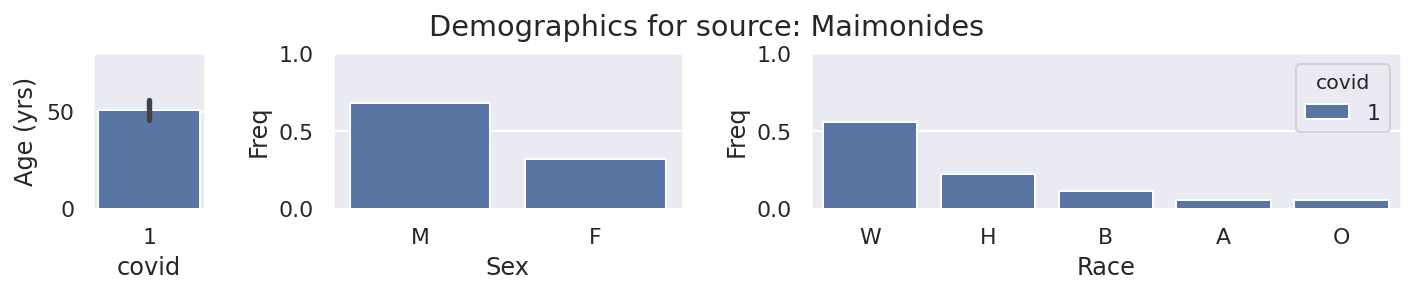

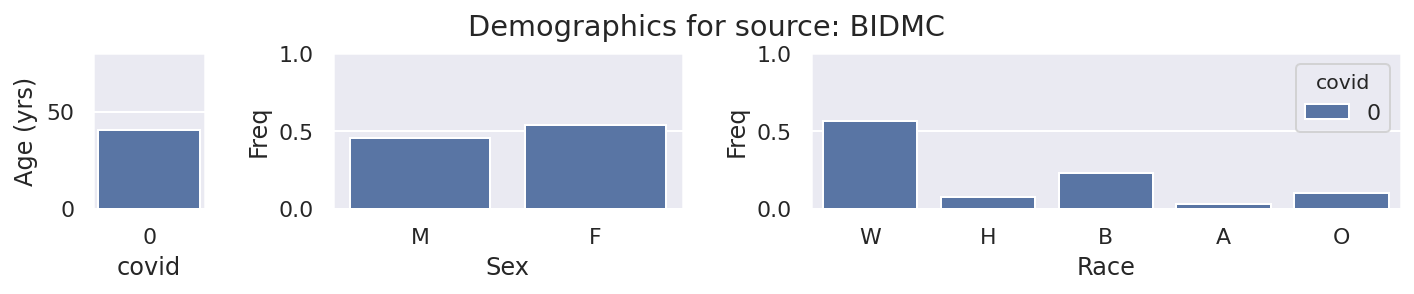

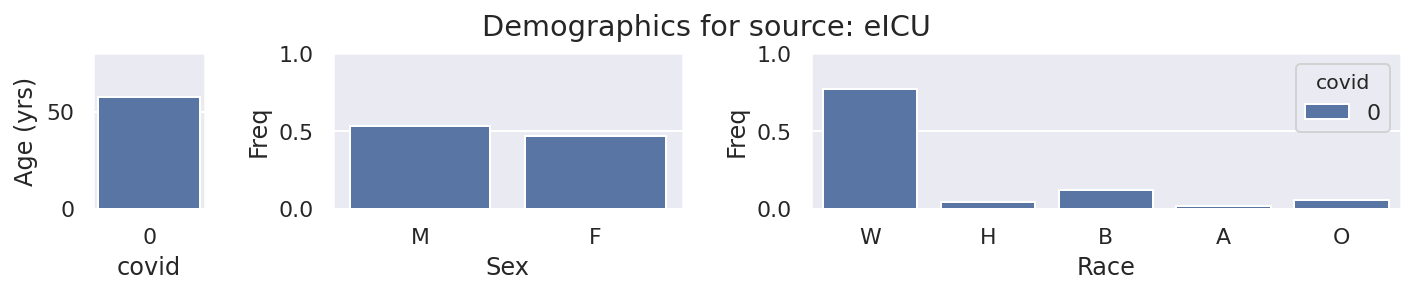

In [23]:
#@title

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

plot_sources(df_data_raw, ycol='covid')
plot_demo(df_data_raw, ycol='covid', title='Demographics for all sources')
for src in CONFIG_DATA_SRC:
  plot_demo(df_data_raw[df_data_raw['Source']==src], ycol='covid', title=f'Demographics for source: {src}')

# Panel definitions

In [0]:
PANEL_CBC = (
   COL.wbc
  ,COL.rbc
  ,COL.hemoglobin
  ,COL.hematocrit
  ,COL.mcv
  ,COL.mch
  ,COL.mchc
  ,COL.rdw
  ,COL.platelet
  ,COL.neutrophils
  ,COL.lymphocytes
  ,COL.monocytes
  ,COL.eosinophils
  ,COL.basophils
)

PANEL_CBC_REFLEX = (
   COL.bands
  ,COL.atypical
  ,COL.myelocytes
  ,COL.metamyelocytes
)

PANEL_BMP = (
   COL.sodium
  ,COL.potassium
  ,COL.chloride
  ,COL.bicarbonate
  ,COL.bun
  ,COL.creatinine
  ,COL.glucose
  ,COL.calcium
)

PANEL_LIVER = (
   COL.albumin
  ,COL.alanine
  ,COL.asparate
  ,COL.alkaline
  ,COL.bilirubin
)

PANEL_CMP = PANEL_BMP + PANEL_LIVER

PANEL_COAGS = (
  COL.pt
 ,COL.ptt
)

PANEL_VBG = (
   COL.ph
  ,COL.pco2
  ,COL.po2
)

VITALS = (
   COL.temp
  ,COL.pulse
  ,COL.sysbp
  ,COL.diabp
  ,COL.respr
  ,COL.spo2
)

DEMO = (
   COL.age
  ,COL.sex
  ,COL.race
)

# Configuration

In [0]:
CONFIG_COMPANY = 'Biocogniv'
CONFIG_DX_TITLE = 'COVID-19'

CONFIG_SOURCES = [
                  'UVMMC', 
                  'Cedars-Sinai',
                  'Maimonides',
                  'eICU', 
                  'BIDMC'
                  ]
CONFIG_SEED = 0 # random seed
np.random.seed(CONFIG_SEED)

# CONFIG_FEATS = VITALS + PANEL_CBC + PANEL_BMP
CONFIG_FEATS = VITALS + (COL.wbc, COL.hemoglobin,	COL.platelet, COL.sodium, COL.potassium, COL.chloride, COL.bicarbonate,	COL.glucose, COL.bun, COL.creatinine, COL.calcium)
CONFIG_FEATS = list(CONFIG_FEATS)

# CONFIG_FEATS_MANDATORY = [COL.temp, COL.sodium, COL.wbc]
CONFIG_FEATS_MANDATORY = CONFIG_FEATS

# CONFIG_MODEL = XGBClassifier(random_state=CONFIG_SEED)
CONFIG_MODEL = CatBoostClassifier(random_state=CONFIG_SEED, verbose=False, cat_features=[CONFIG_FEATS.index(el) for el in CONFIG_FEATS if el in [COL.sex, COL.race]])
# CONFIG_MODEL = LGBMClassifier(random_state=CONFIG_SEED)
# CONFIG_MODEL = DecisionTreeClassifier(class_weight='balanced', random_state=CONFIG_SEED)
# CONFIG_MODEL = ExtraTreesClassifier(class_weight='balanced', random_state=CONFIG_SEED)
# CONFIG_MODEL = RandomForestClassifier(class_weight='balanced', random_state=CONFIG_SEED)
# CONFIG_MODEL = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=CONFIG_SEED)

CONFIG_CALIBRATE = 'sigmoid' # options are 'sigmoid', 'isotonic', or None
CONFIG_K = 5
CONFIG_AUC0_MAXFPR = 0.2
CONFIG_DEMO_REWEIGHT = [COL.sex, COL.race] # list of cols e.g. [COL.sex, COL.race]; None for not demographic controls
CONFIG_CLASS_REWEIGHT = False # reweight to balance classes?

def apply_feature_filters(df):
  mask = (df[COL.age]>=20) & (df[COL.temp]>50) & (df[COL.temp]<120)
  # mask = mask & (df['icuadmit']==1)
  return df[mask]

def apply_lod_fill(df_):
  # Fill Eos and Basos if other 3 exist
  df = df_.copy()
  mask = (df[COL.neutrophils]>0) & (df[COL.lymphocytes]>0) & (df[COL.monocytes]>0)
  df[mask] = df[mask].fillna(value={COL.eosinophils:0, COL.basophils:0})
  return df

def apply_controls_filters(df):
  # mask = [True]*len(df) # no filter
  # mask = ~df['ed_ccsrs'].str.contains('INJ',na=False)
  mask = (~df['Source'].isin(['BIDMC', 'eICU'])) | df['ed_ccsrs'].str.contains('RSP')
  return df[mask]

# Pipeline

## Initialization

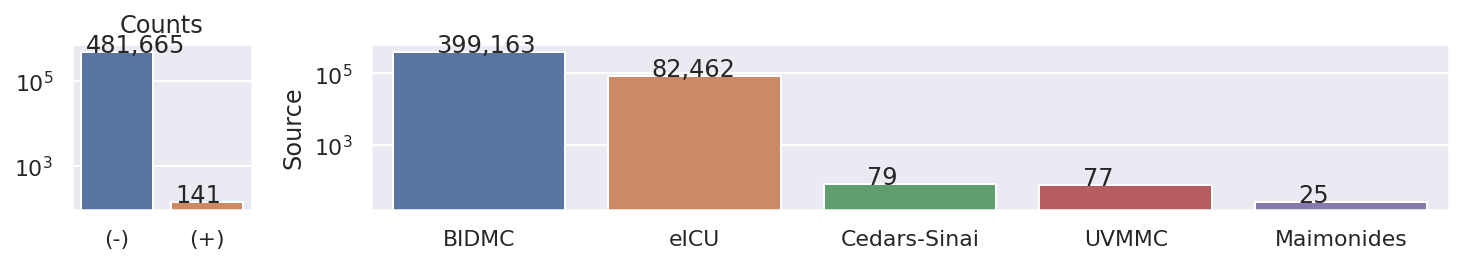

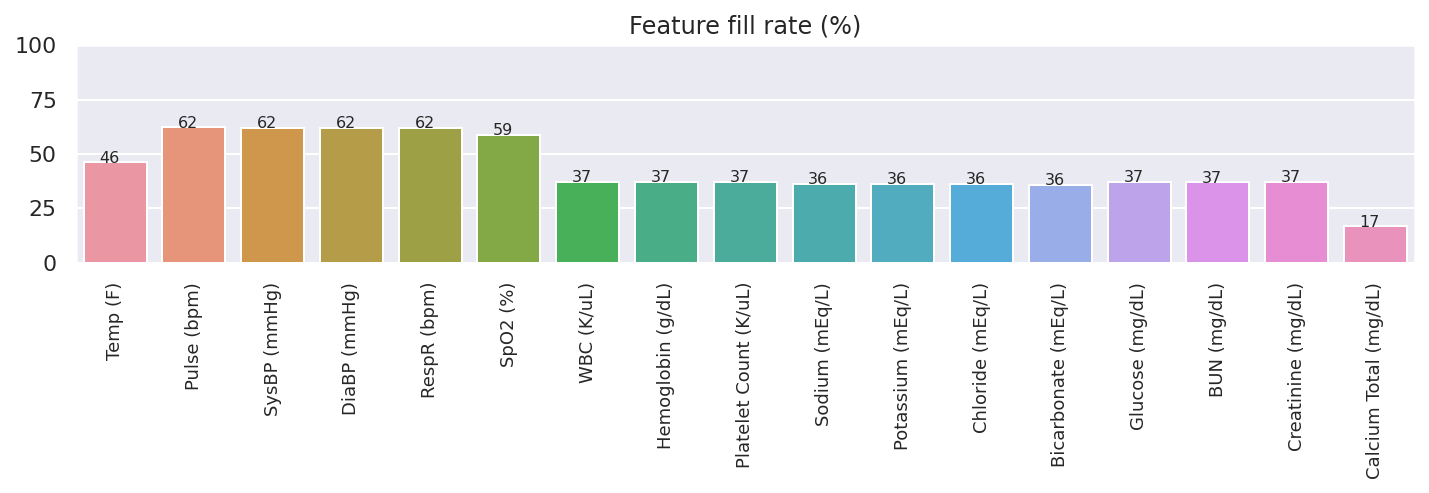

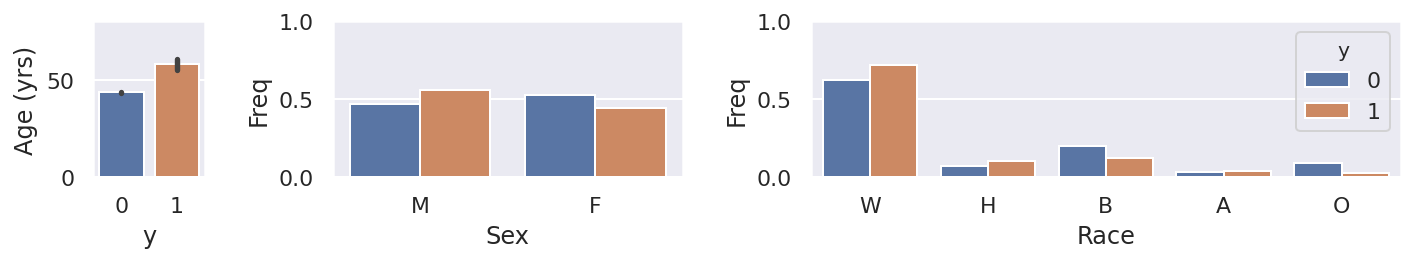

In [122]:
#@title
df_data = df_data_raw
df_data['y'] = df_data['covid']
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])
plot_demo(df_data)

## Source selection

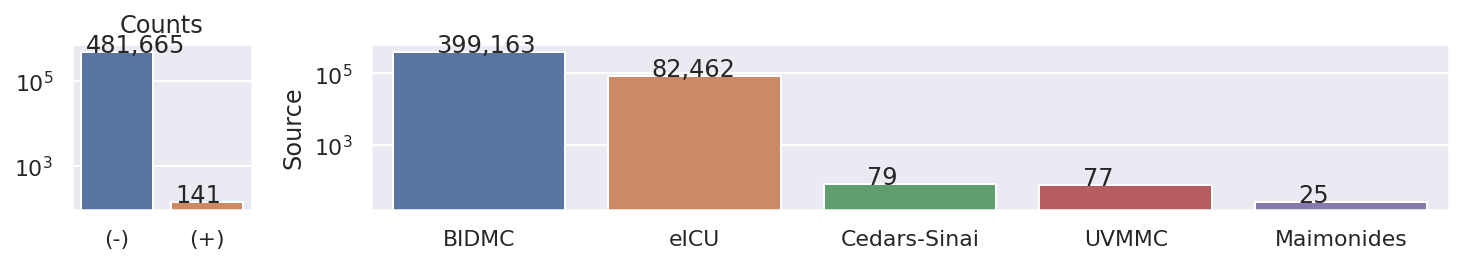

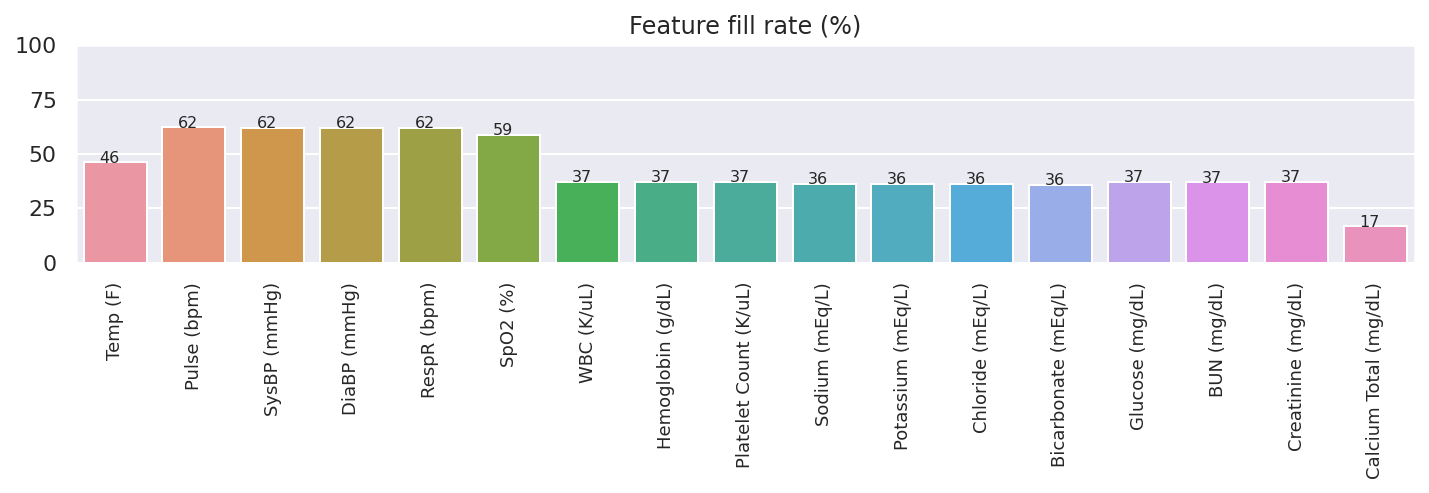

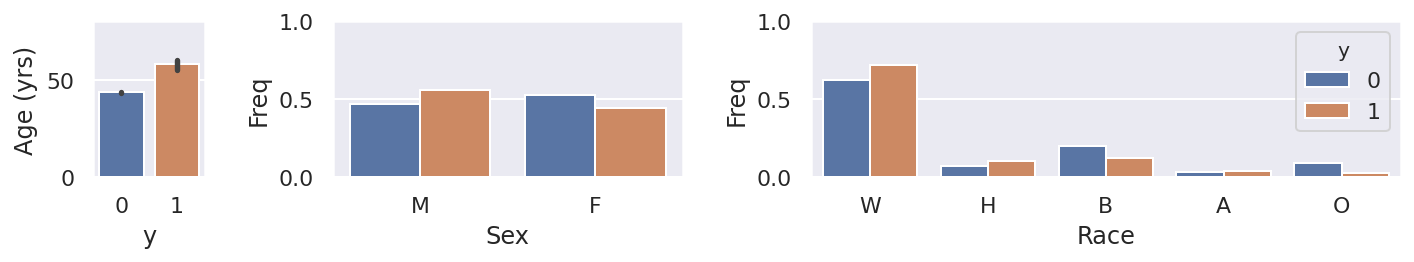

In [123]:
#@title
df_data = df_data[df_data['Source'].isin(CONFIG_SOURCES)]
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])
plot_demo(df_data)

## Feature filters

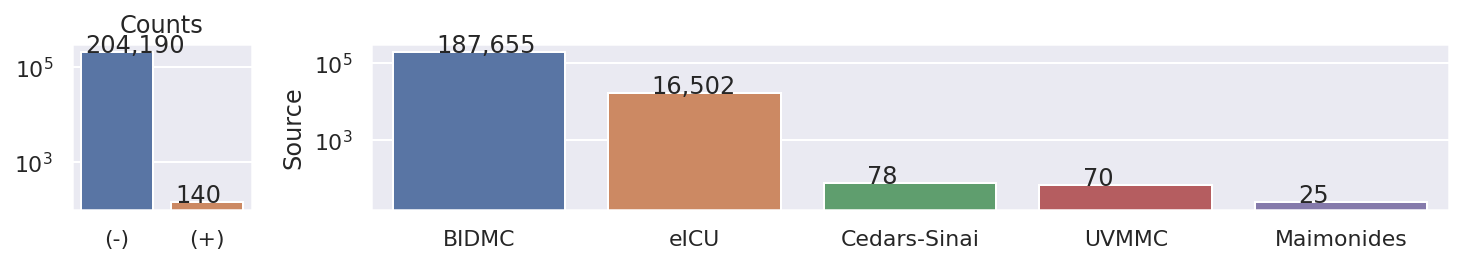

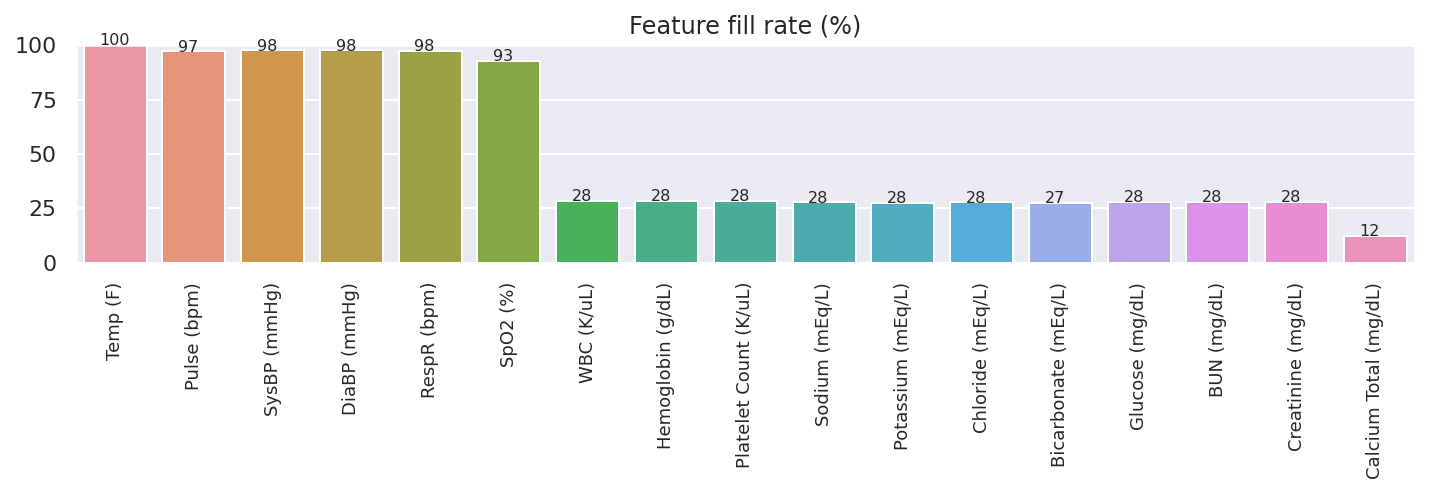

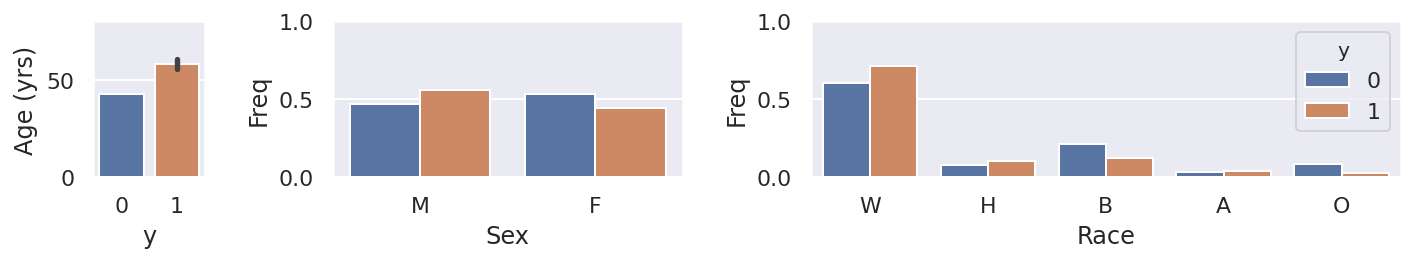

In [124]:
#@title
df_data = apply_feature_filters(df_data)
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])
plot_demo(df_data)

## LoD fills

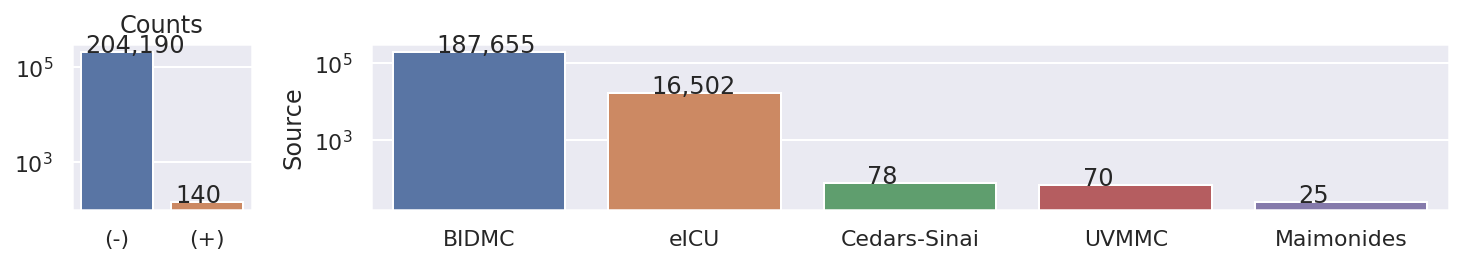

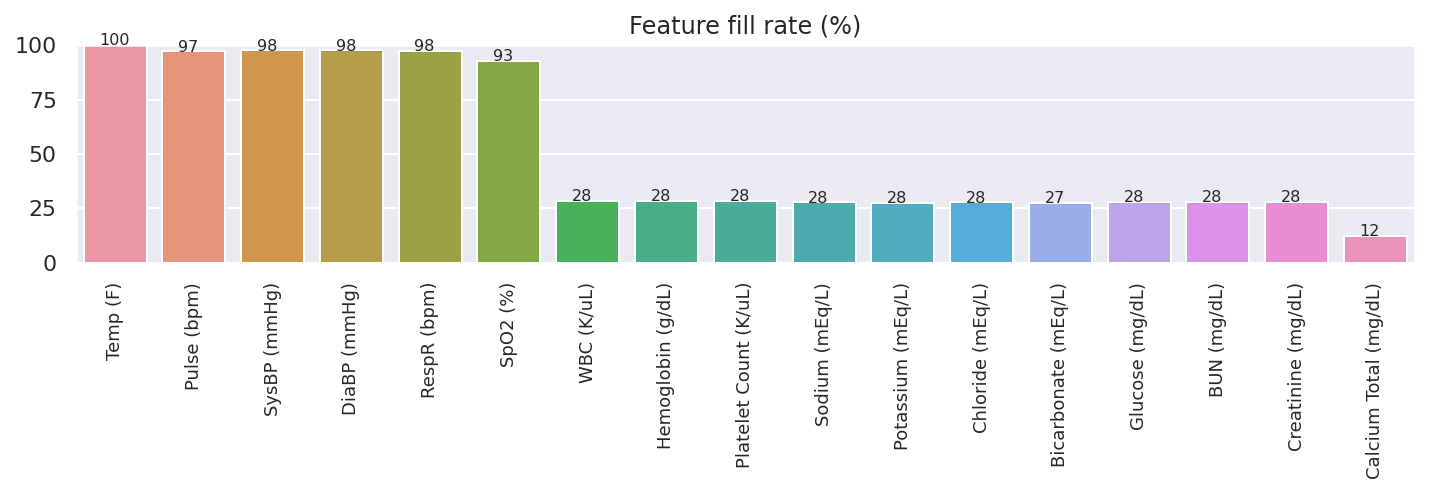

In [125]:
#@title
df_data = apply_lod_fill(df_data)
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])

## Controls filters

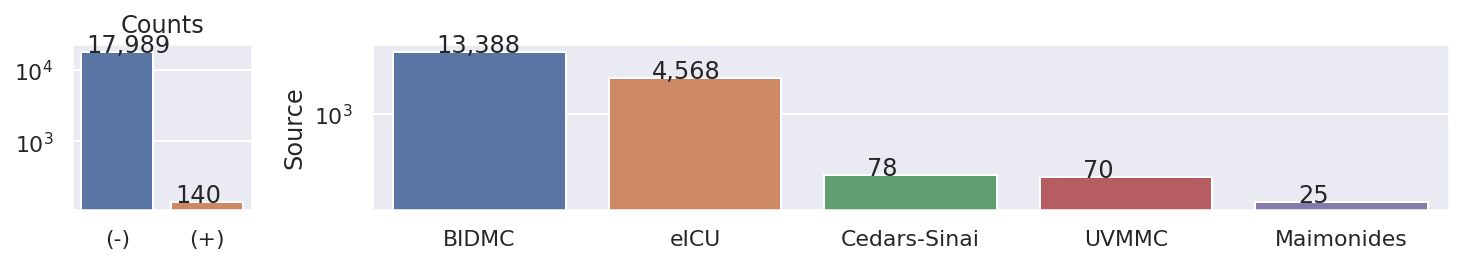

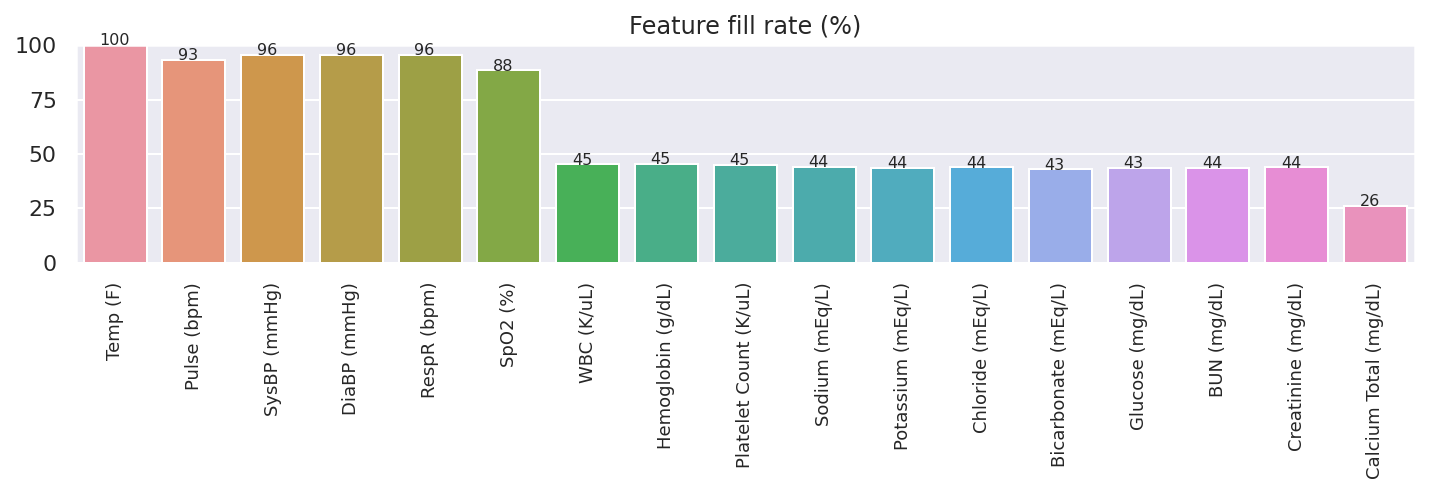

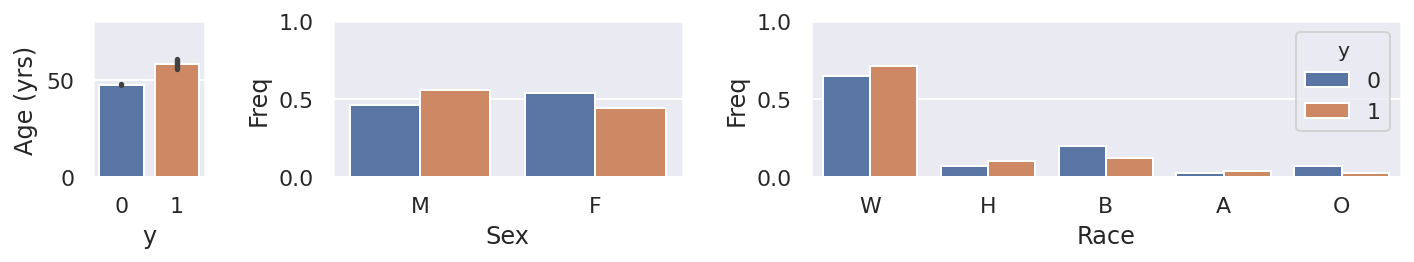

In [126]:
#@title
df_data = apply_controls_filters(df_data)
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])
plot_demo(df_data)

## Drop missing mandatory feats

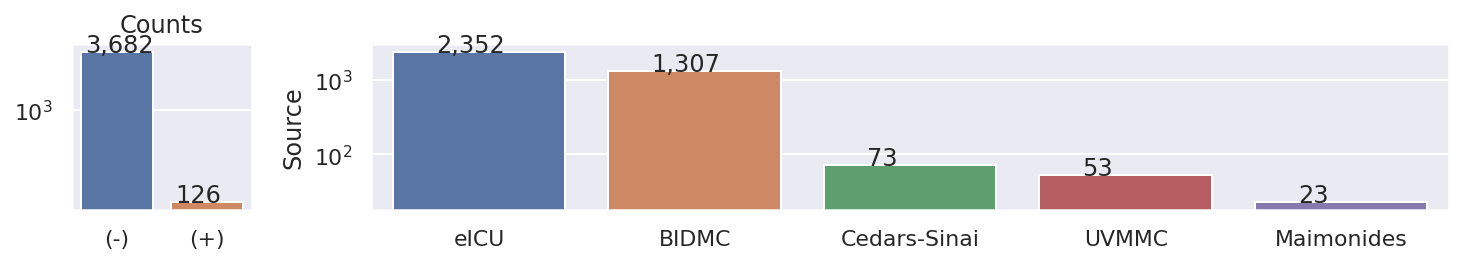

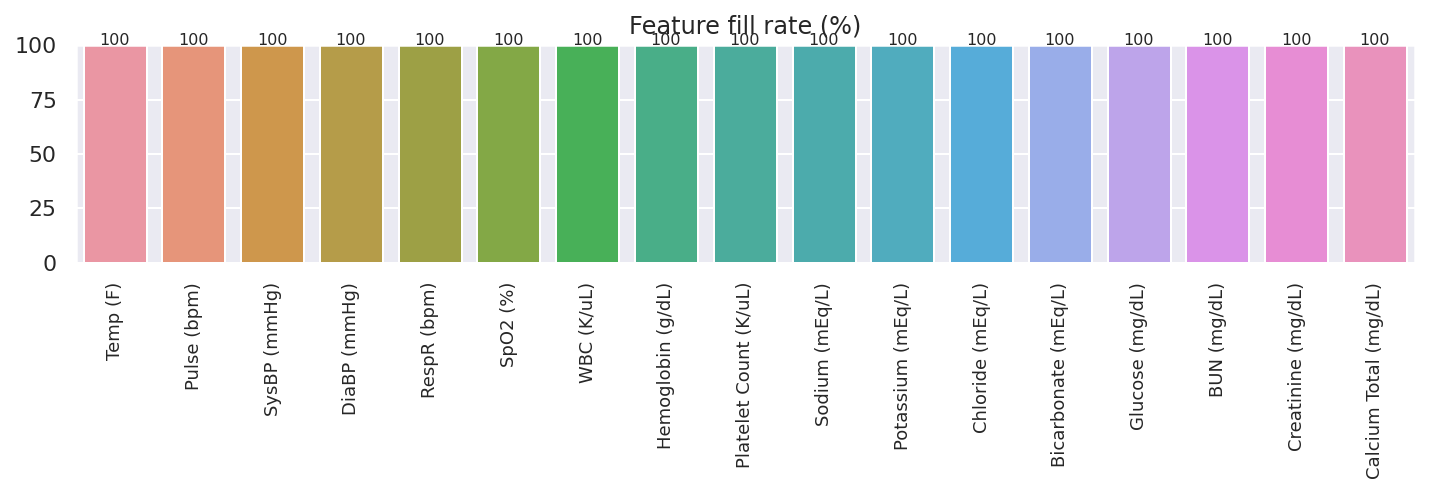

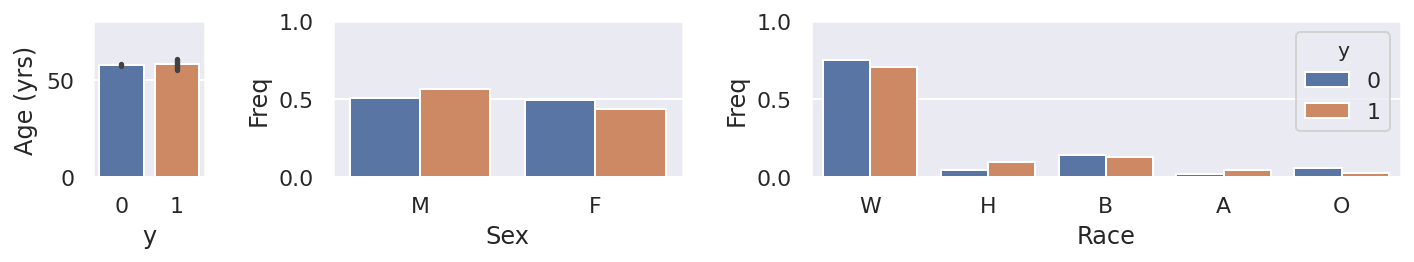

In [127]:
#@title
df_data = df_data.dropna(subset=CONFIG_FEATS_MANDATORY)
plot_sources(df_data)
plot_fillrate(df_data[CONFIG_FEATS])
plot_demo(df_data)

## Control for demographics

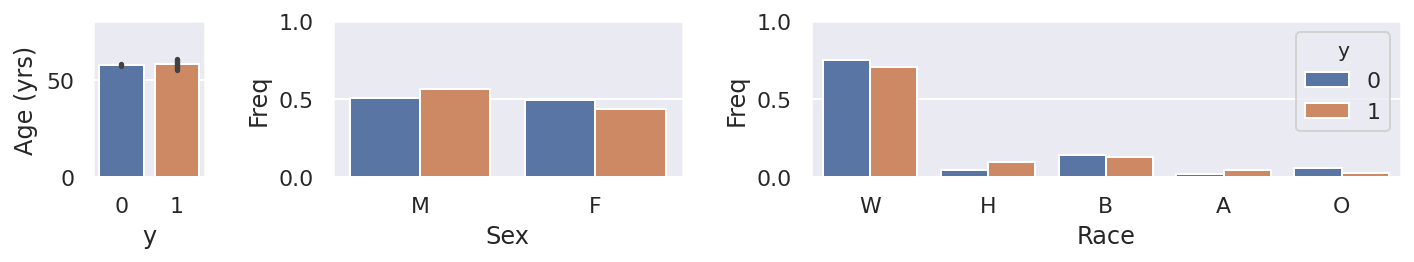

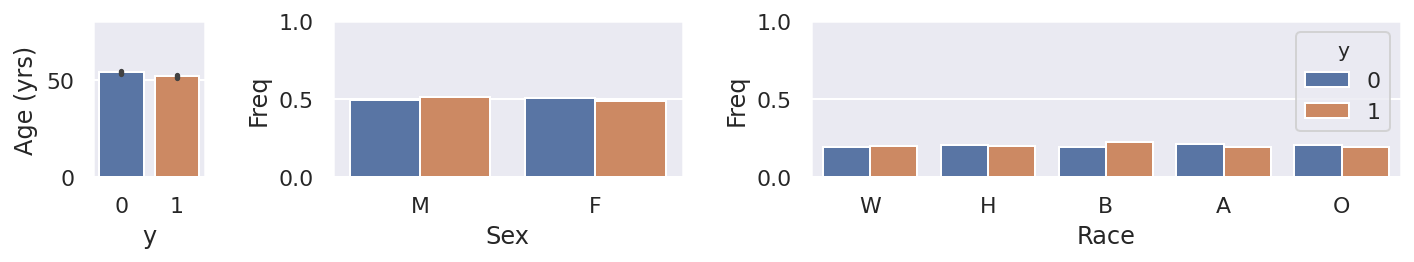

In [128]:
#@title
def get_sample_weights(df):
  df_freqs = df.groupby(CONFIG_DEMO_REWEIGHT).size().reset_index(name='Count')  
  return df[CONFIG_DEMO_REWEIGHT].apply(lambda row: 1.0/df_freqs[(df_freqs[CONFIG_DEMO_REWEIGHT]==row[CONFIG_DEMO_REWEIGHT]).all(axis=1)].iloc[0]['Count'], axis=1)

if CONFIG_DEMO_REWEIGHT!=None:
  df_notna = df_data[df_data[CONFIG_DEMO_REWEIGHT].notna().all(axis=1)]
  df0 = df_notna[df_notna['y']==0]
  df0['w'] = get_sample_weights(df0)

  df1 = df_notna[df_notna['y']==1]
  df1['w'] = get_sample_weights(df1)

  df_na = df_data[~df_data[CONFIG_DEMO_REWEIGHT].notna().all(axis=1)]
  df_na['w'] = pd.concat([df0, df1])['w'].median()

  df = pd.concat([df0, df1, df_na])
  plot_demo(df)
  plot_demo(df.sample(frac=1.0, weights=df['w'], replace=True))

  df_data['w'] = df['w']
else:
  df_data['w'] = 1 # do nothing with the weights

## Class imbalance reweighting

In [129]:
#@title
if CONFIG_CLASS_REWEIGHT:
  neg_pos_ratio = (len(df_data['y'])-df_data['y'].sum()) / df_data['y'].sum()
  df_data['w'] = df_data.apply(lambda row: row['w']*(1 + neg_pos_ratio*row['y']), axis=1)

  plot_demo(df_data)
  plot_demo(df_data.sample(frac=1.0, weights=df_data['w'], replace=True))
else:
  print('Nothing do do')

Nothing do do


## Impute missing features

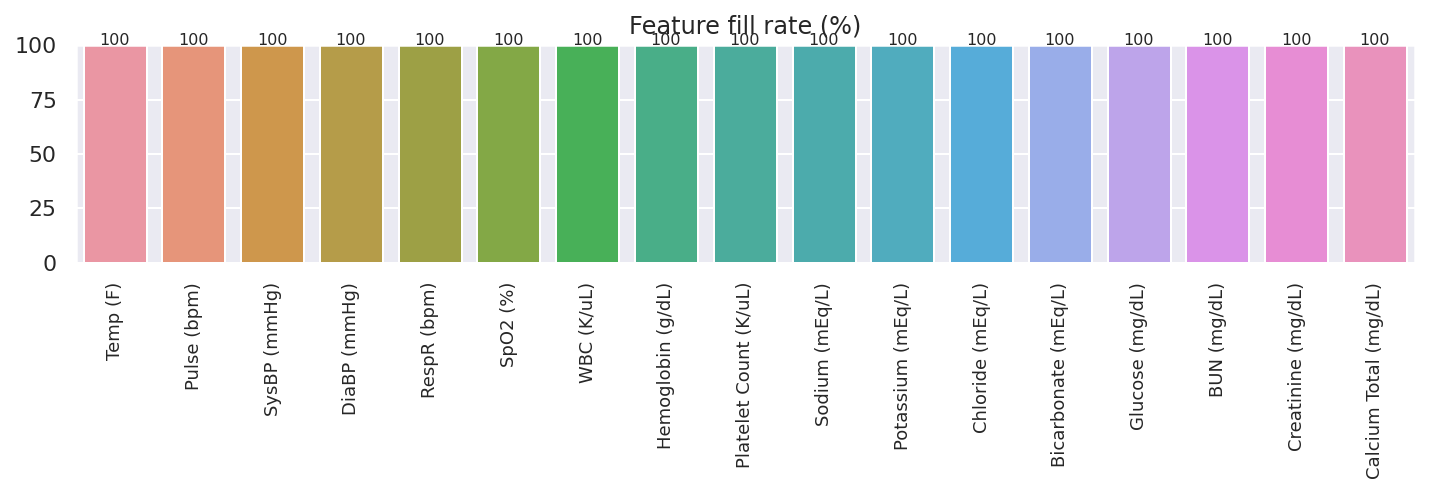

In [130]:
#@title
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#
# Imputation - must come *after* resampling (else imputed mean will not
# reflect the resampled distribution) and *after* non-mandatory dropna
# (otherwise will lose information of NaNs)
# 
imp = IterativeImputer(missing_values=np.nan, random_state=CONFIG_SEED)
df_feats = df_data[CONFIG_FEATS]

if df_feats.applymap(np.isreal).values.all():
  df_feats = pd.DataFrame(imp.fit_transform(df_feats), index=df_feats.index, columns=df_feats.columns)
  df_data = df_data.drop(columns=CONFIG_FEATS).join(df_feats)
  plot_fillrate(df_data[CONFIG_FEATS])
else:
  print('Could not impute data (non-numeric columns found)')

# Show time

## Stats

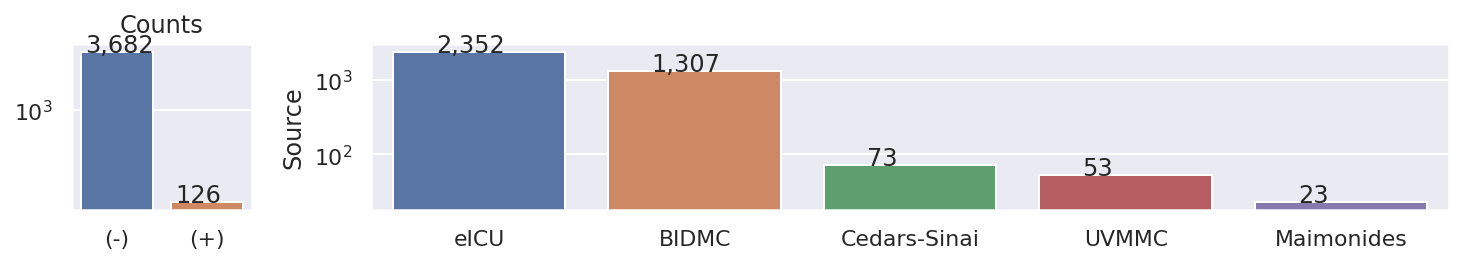

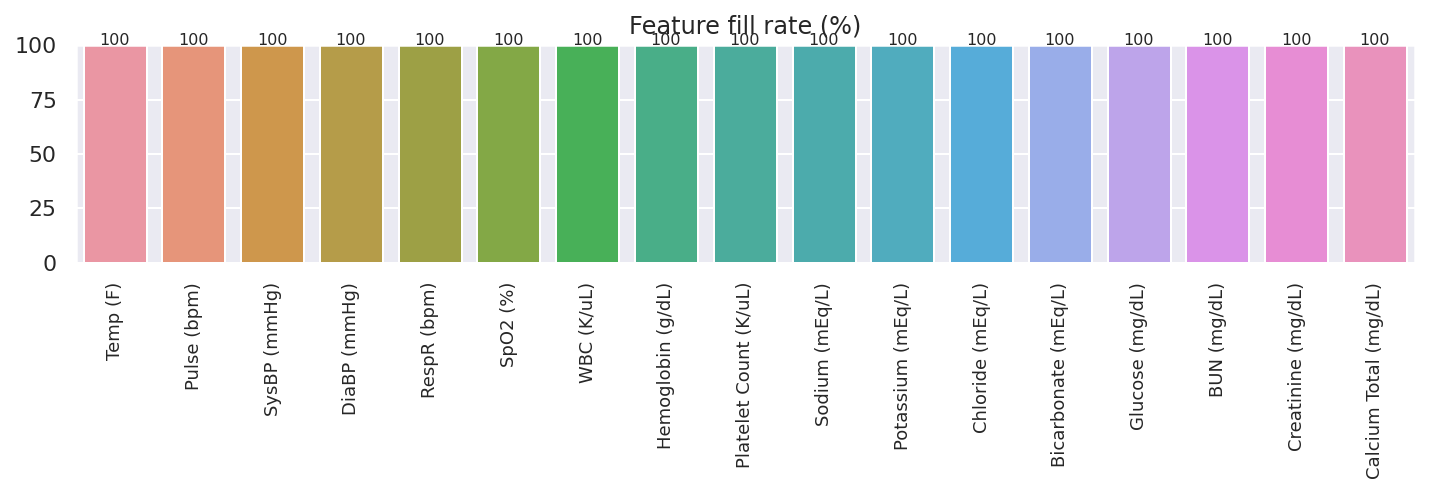

As-is demographics


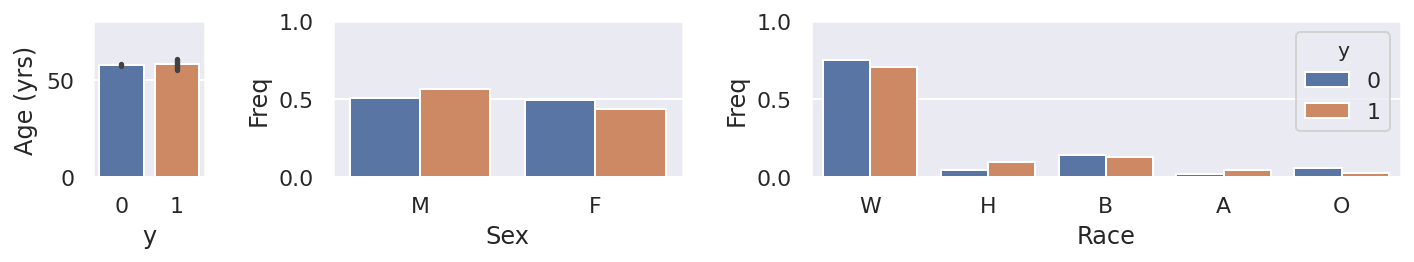

Reweighted demographics


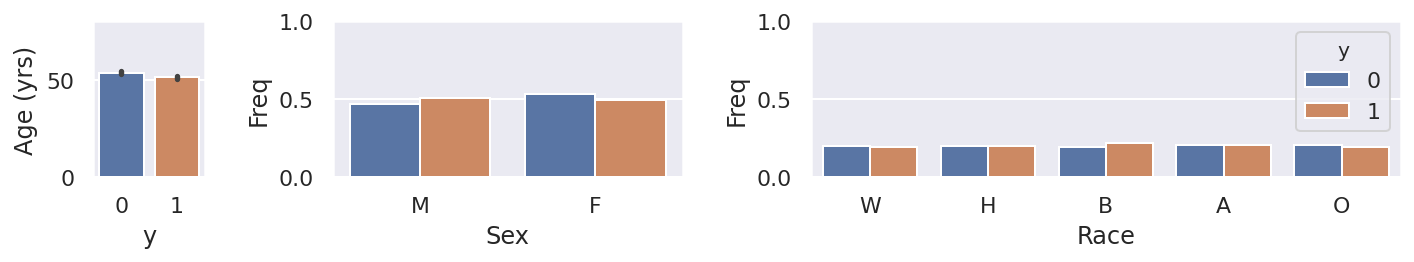

In [131]:
#@title
plot_sources(df_data)
if LOG_EXPERIMENT:
  exp.log_figure(figure_name='Data source stats', figure=plt)
plt.show()

plot_fillrate(df_data[CONFIG_FEATS])
if LOG_EXPERIMENT:
  exp.log_figure(figure_name='Feature fill rate', figure=plt)
plt.show()

print('As-is demographics')
plot_demo(df_data)
if LOG_EXPERIMENT:
  exp.log_figure(figure_name='As-is demographics', figure=plt)
plt.show()

print('Reweighted demographics')
plot_demo(df_data.sample(frac=1.0, weights=df_data['w'], replace=True))
if LOG_EXPERIMENT:
  exp.log_figure(figure_name='Reweighted Demographics', figure=plt)
plt.show()
  


## Generate X,y,w from df_data

In [132]:
#@title
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

if df_data.index.duplicated().sum()>0:
  raise Exception('**************** DUPLICATE DATA FOUND!!!')

#
# Get X,y,w
#
X = df_data[CONFIG_FEATS].values
y = df_data['y'].values
w = df_data['w'].values

print(f'Number of records  : {len(df_data):,}')
print(f'        Positives  : {df_data["y"].sum():,}')
print(f'Number of features : {X.shape[1]:,}')

print()
print('Source counts')
print('=============')
print(df_data['Source'].value_counts().sort_values())
print()

<IPython.core.display.Javascript object>

Number of records  : 3,808
        Positives  : 126
Number of features : 17

Source counts
Maimonides        23
UVMMC             53
Cedars-Sinai      73
BIDMC           1307
eICU            2352
Name: Source, dtype: int64



## Exploration

### K-fold scan of K?

In [0]:
# from sklearn.model_selection import cross_val_score

# ks = range(2, 20, 2)
# kmeans = []
# kstd = []
# for k in ks:
#   scores = cross_val_score(CONFIG_MODEL, X, y, cv=k, scoring='roc_auc')
#   kmeans.append(scores.mean())
#   kstd.append(scores.std())
#   print("k=%i: %0.2f (+/- %0.2f)" % (k, kmeans[-1], kstd[-1] * 2))

# plt.errorbar(ks, kmeans, yerr=kstd, fmt='o')
# plt.show()

### Hyperparameter optimization?

In [0]:
# # CONFIG_MODEL.set_params(**{'scale_pos_weight': 1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2, 'l2_leaf_reg': 1.0})

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_val_score

# def custom_score(y_true, y_proba):
#   # AUC
#   fpr, tpr, thresh = metrics.roc_curve(y_true, y_proba)
#   # auc = metrics.auc(fpr[fpr<=0.2], tpr[fpr<=0.2])
#   auc = metrics.auc(fpr, tpr)
#   auc = auc if auc>0.5 else 1-auc
#   return auc 

#   # Sensitivity
#   # fpr, tpr, thresh = metrics.roc_curve(y_true, y_proba)
#   # fprs = np.linspace(0, 1, 100)
#   # tprs = np.interp(fprs, fpr, tpr)
#   # return tprs[fprs>0.50].mean()

#   # Specificity
#   # fpr, tpr, thresh = metrics.roc_curve(y_true, y_proba)
#   # tprs = np.linspace(0, 1, 100)
#   # fprs = np.interp(tprs, tpr, fpr)
#   # return 1 - fprs[tprs<0.50].mean()

# # XGBoost
# params = {
#   'n_estimators':[100,1000,5000],
#   'max_delta_step':[0,1,5],
#   'learning_rate':[0.01,0.1,0.5],
#   'max_depth':[3,6,8],
#   'min_child_weight':[1,10,100],
#   'subsample':[0.5,0.8,1.0],
#   'scale_pos_weight':[1,10,100],
#   'lambda':[0.5,1,2]
# }

# # # CatBoost
# # params = {
# #   'learning_rate':[0.05, 0.1, 0.2],
# #   'max_depth':[3,6,12],
# #   'n_estimators':[500, 1000, 2000],
# #   'l2_leaf_reg':[1.0, 3.0, 6.0],
# #   'scale_pos_weight':[1, 10, 100]
# # }

# m = XGBClassifier()
# # m = LGBMClassifier()
# # m = CatBoostClassifier(verbose=False)

# print('baseline auc:', cross_val_score(m, X, y, cv=5, scoring='roc_auc').mean())

# # gs = GridSearchCV(m, params, cv=2, verbose=1, scoring=make_scorer(custom_score, needs_proba=True))
# gs = RandomizedSearchCV(m, cv=3, param_distributions=params, n_iter=20)
# gs.fit(X, y, sample_weight=w)

# df = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
# display(df[['rank_test_score','mean_test_score','std_test_score','params']])

### Feature elimination?

In [0]:
# from sklearn.feature_selection import RFECV

# cv = StratifiedKFold(n_splits=CONFIG_K, shuffle=True, random_state=CONFIG_SEED)
# fe = RFECV(estimator=CONFIG_MODEL, step=1, cv=cv, scoring='roc_auc')
# fe.fit(X, y)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(fe.grid_scores_) + 1), fe.grid_scores_)
# plt.ylim(0.6, 1.0)
# plt.show()

# pd.DataFrame({'feat':CONFIG_FEATS, 'rank':fe.ranking_})

### AUC vs N?

In [0]:
# from sklearn.model_selection import cross_val_score

# N_max = (df_data['y']==1).sum()
# Nrange = range(20, N_max, 10)
# means = []
# stds = []
# CONFIG_SEED = 0
# for N in Nrange:
#   df_neg = df_data[df_data['y']==0]
#   df_pos = df_data[df_data['y']==1].sample(n=N, random_state=CONFIG_SEED)
#   df = pd.concat([df_neg, df_pos])
#   X = df[CONFIG_FEATS].values
#   y = df['y'].values

#   m = XGBClassifier(random_state=CONFIG_SEED, scale_pos_weight=(len(y)-y.sum())/y.sum())
#   scores = cross_val_score(CONFIG_MODEL, X, y, cv=CONFIG_K, scoring='roc_auc')
#   means.append(scores.mean())
#   stds.append(scores.std())
#   print("N=%i: %0.2f (+/- %0.2f)" % (N, means[-1], stds[-1] * 2))

# plt.errorbar(Nrange, means, yerr=stds, fmt='o')
# plt.show()

## Train and test

In [137]:
#@title
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

# Prevent cell scrolling
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

#
# Sanity checks
#
if (pd.isna(X).any()):
  raise Exception('**************** MISSING DATA FOUND in X!!!')
if (pd.isna(y).any()):
  raise Exception('**************** MISSING DATA FOUND in y!!!')
if (pd.isna(w).any()):
  raise Exception('**************** MISSING DATA FOUND in w!!!')

print()
print('Population for AI training/testing')
print('=====================================')
print(f'Total             : {len(y):,}')
print(f'  Negatives       : {len(y)-y.sum():,}')
print(f'  Positives       : {y.sum():,}')
print(f'  Prevalence      : {100*y.sum()/len(y):.2f}%')

i = 0
K = CONFIG_K
ai_stats = {'auroc': 0, 'auroc0': 0}
fpr_tprs = []
prec_recalls = []
auc_marker = [0] * X.shape[1]
df_coef = pd.DataFrame(columns=CONFIG_FEATS)

# Add AI output col
df_data['proba'] = pd.Series(index=df_data.index, dtype=float)

splitter = StratifiedKFold(n_splits=K, shuffle=True, random_state=CONFIG_SEED)
# splitter = StratifiedShuffleSplit(n_splits=K, test_size=0.5, random_state=CONFIG_SEED)
for train, test in splitter.split(X, y):
    i += 1
    X_train, y_train, w_train, X_test, y_test = X[train], y[train], w[train], X[test], y[test]

    # Train it
    m = CONFIG_MODEL # important when calibrating! (otherwise m will host calibration state)
    m.fit(X_train, y_train, sample_weight=w_train)

    # Get feature importances
    if hasattr(m, 'coef_'):
      df_coef.loc[i] = m.coef_[0]
    if hasattr(m, 'feature_importances_'):
      df_coef.loc[i] = m.feature_importances_

    # Calibrate it?
    if CONFIG_CALIBRATE!=None:
      m = CalibratedClassifierCV(m, method=CONFIG_CALIBRATE, cv=CONFIG_K)
      m.fit(X_train, y_train, sample_weight=w_train)

    # Test it
    y_proba = m.predict_proba(X_test)[:, 1]
    df_data['proba'].iloc[test] = y_proba

    # Test: AI metrics
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_proba)
    fpr_tprs.append((fpr, tpr, thresh))
    prec, recall, thresh = metrics.precision_recall_curve(y_test, y_proba)
    prec_recalls.append((prec, recall, thresh))
    # Total AUC
    auc = metrics.roc_auc_score(y_test, y_proba)
    auc = 1 - auc if auc<0.5 else auc
    ai_stats['auroc'] += auc / K
    # Partial AUC
    auc = metrics.roc_auc_score(y_test, y_proba, max_fpr=CONFIG_AUC0_MAXFPR)
    auc = 1 - auc if auc<0.5 else auc
    ai_stats['auroc0'] += auc / K

    # Test: Marker metrics
    for imarker in range(X.shape[1]):
      if not np.isreal(X[0][imarker]):
        continue
      # Remove NaNs consistently between X and y
      df = pd.DataFrame(X_test[:, imarker], columns=['X'])
      df = df.join(pd.DataFrame(y_test, columns=['y']))
      df = df.dropna()
      auc = metrics.roc_auc_score(df['y'], df['X'])
      auc = 1 - auc if auc<0.5 else auc
      auc_marker[imarker] += auc / K

# Get most important features (by AUC, and AI importance)
config_feats = pd.Series(CONFIG_FEATS)
df_imp = pd.DataFrame(df_coef.mean(axis=0).sort_values(ascending=False).rename('importance'))
df_imp['importance'] = df_imp['importance'].apply(lambda x: round(100*x,2))
df_auc = pd.DataFrame({'auc':auc_marker}).join(config_feats.rename('feature'))
df_auc['X_index'] = df_auc.index
df_auc['auc'] = df_auc['auc'].apply(lambda x: round(100*x,2))
df_auc = df_auc.set_index('feature')
df_top_feats = df_imp.join(df_auc).sort_values(by='importance', ascending=False)
df_top_feats.index.names = ['feature']

# Compile remaining ai_stats
fpr, tpr, thresh = metrics.roc_curve(df_data['y'], df_data['proba'])
ai_stats['roc_sens'], ai_stats['roc_spec'], ai_stats['roc_thresh'] = tpr[::-1], (1-fpr[::-1]), thresh[::-1]
ai_stats['pr_prec'], ai_stats['pr_rec'], ai_stats['pr_thresh'] = metrics.precision_recall_curve(df_data['y'], df_data['proba'])

print()
print(f"Total AUROC   : {100*ai_stats['auroc']:.2f}%")
print(f"Partial AUROC : {100*ai_stats['auroc0']:.2f}%")

# Dx title
if CONFIG_DX_TITLE==None:
  dx_title = f"{df_icd_codes.loc[CONFIG_DX]['short_title']} ({CONFIG_DX})" if CONFIG_DX in df_icd_codes.index else None
  if dx_title==None:
    dx_title = f"{df_ccsr_codes.loc[CONFIG_DX]['title']} ({CONFIG_DX})" if CONFIG_DX in df_ccsr_codes.index else None
  if dx_title==None:
    dx_title = CONFIG_DX
else:
  dx_title = CONFIG_DX_TITLE

<IPython.core.display.Javascript object>


Population for AI training/testing
Total             : 3,808
  Negatives       : 3,682
  Positives       : 126
  Prevalence      : 3.31%

Total AUROC   : 90.89%
Partial AUROC : 81.59%


## ROCs/AUCs

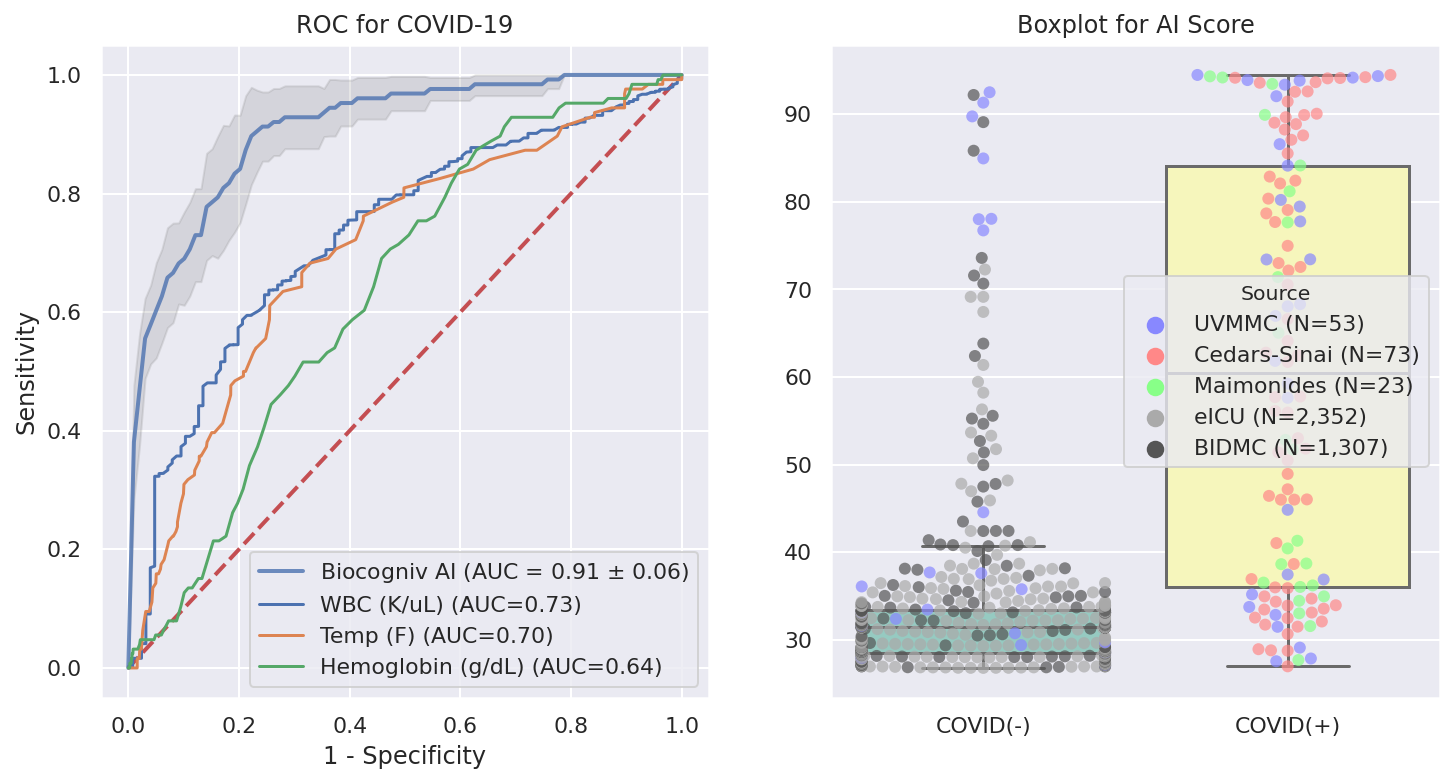

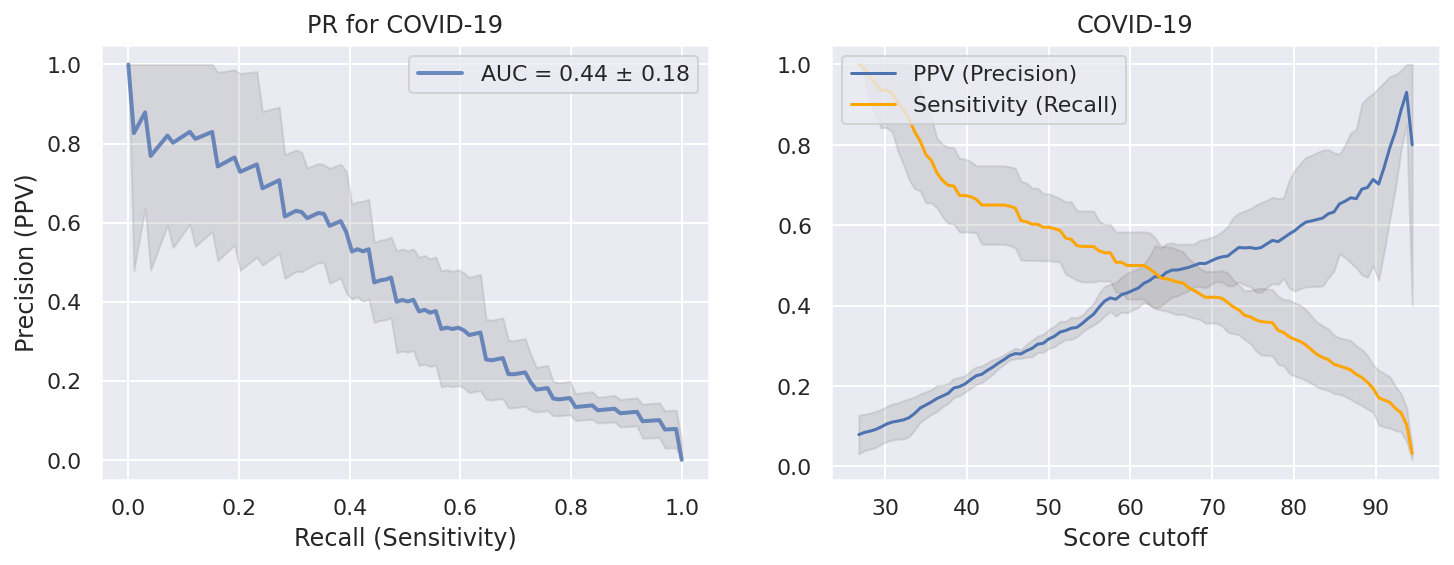

,Sensitivity (%),Specificity (%),Precision (%),Recall (%)
Cutoff,,,,
0.0,100.00,0.00,3.47,100.00
5.0,100.00,0.00,3.47,100.00
10.0,100.00,0.00,3.47,100.00
15.0,100.00,0.00,3.47,100.00
20.0,100.00,0.00,3.47,100.00
25.0,100.00,0.00,3.47,100.00
30.0,93.65,42.16,5.36,93.65
35.0,76.98,84.12,14.24,76.98
40.0,67.46,91.24,20.48,67.46


In [138]:
#@title
plt.figure(figsize=(12,6))

#
# PLOT ROC AND MARKERS
#
plt.subplot(1, 2, 1)
plot_roc(fpr_tprs, dx_title, f'{CONFIG_COMPANY} AI')
for i in range(3 if len(df_top_feats)>3 else len(df_top_feats)):
  X_idx = df_top_feats.iloc[i]['X_index'].astype(int)
  # Remove NaNs from X, consistently with y
  df = pd.DataFrame(X[:, X_idx], columns=['X'])
  df = df.join(pd.DataFrame(y, columns=['y']))
  df = df.dropna()
  plot_marker_roc(CONFIG_FEATS[X_idx], df['X'], df['y'], False)

#
# BOXPLOT
#
plt.subplot(1, 2, 2)
df = df_data.copy()

pal_box = sns.color_palette("Set3")
pal_swarm = ['#88f', '#f88', '#8f8', '#aaa', '#555']
labels = ['COVID(-)', 'COVID(+)']
source_labels = [f"{src} (N={(df['Source']==src).sum():,})" for src in CONFIG_SOURCES]
source_dict = {CONFIG_SOURCES[i]:source_labels[i] for i in range(len(CONFIG_SOURCES))}
downs_mask = (df['Source']=='BIDMC') | (df['Source']=='eICU')

df['y'] = df['y'].replace({0:labels[0], 1:labels[1]})
df['Source'] = df['Source'].replace(source_dict)
df['proba'] = 100*df['proba']

VISUAL_PREVALENCE = 0.2
n_pos = (df['y']==labels[1]).sum()
n_neg = n_pos*(1-VISUAL_PREVALENCE)/VISUAL_PREVALENCE
df_downsampled = pd.concat([ df[~downs_mask], 
                             df[downs_mask].sample(n=int(n_neg), replace=True, random_state=CONFIG_SEED) ])

if CONFIG_CALIBRATE==None:
  plt.yscale('log')
sns.boxplot(x='y', y='proba', data=df, order=labels, palette=[pal_box[0],pal_box[1]], fliersize=0)
sns.swarmplot(x='y', y='proba', hue='Source', data=df_downsampled, order=labels, hue_order=source_labels, palette=pal_swarm, size=6, alpha=0.7)
plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot for AI Score')

if LOG_EXPERIMENT:
  exp.log_figure(figure_name='ROC and Boxplot', figure=plt)
plt.show()

#
# PRECISION RECALL
#

plt.figure(figsize=(12,4))

# Plot PR curve
plt.subplot(1, 2, 1)
plot_prc(prec_recalls, f'PR for {dx_title}', color_num=0)

# Plot PR vs score
plt.subplot(1, 2, 2)
plot_prc_scores(prec_recalls, dx_title)

if LOG_EXPERIMENT:
  exp.log_figure(figure_name='Precision-recall', figure=plt)
plt.show()

# Table: Sens/Spec and PR versus Cutoff
if CONFIG_CALIBRATE==None:
  cutoffs = np.around(np.logspace(-2, 2, 20), 2)
else:
  cutoffs = np.around(np.linspace(0, 100, 21), 2)
sens = np.interp(cutoffs, 100*ai_stats['roc_thresh'], ai_stats['roc_sens'])
spec = np.interp(cutoffs, 100*ai_stats['roc_thresh'], ai_stats['roc_spec'])
prec = np.interp(cutoffs, 100*ai_stats['pr_thresh'], ai_stats['pr_prec'][:-1])
rec = np.interp(cutoffs, 100*ai_stats['pr_thresh'], ai_stats['pr_rec'][:-1])
df1 = pd.DataFrame({'Cutoff':cutoffs, 'Sensitivity (%)':(100*sens).round(2), 'Specificity (%)':(100*spec).round(2)}).set_index('Cutoff')
df2 = pd.DataFrame({'Cutoff':cutoffs, 'Precision (%)':(100*prec).round(2), 'Recall (%)':(100*rec).round(2)}).set_index('Cutoff')
display(df1.join(df2))

# Performance analysis

## By demographics

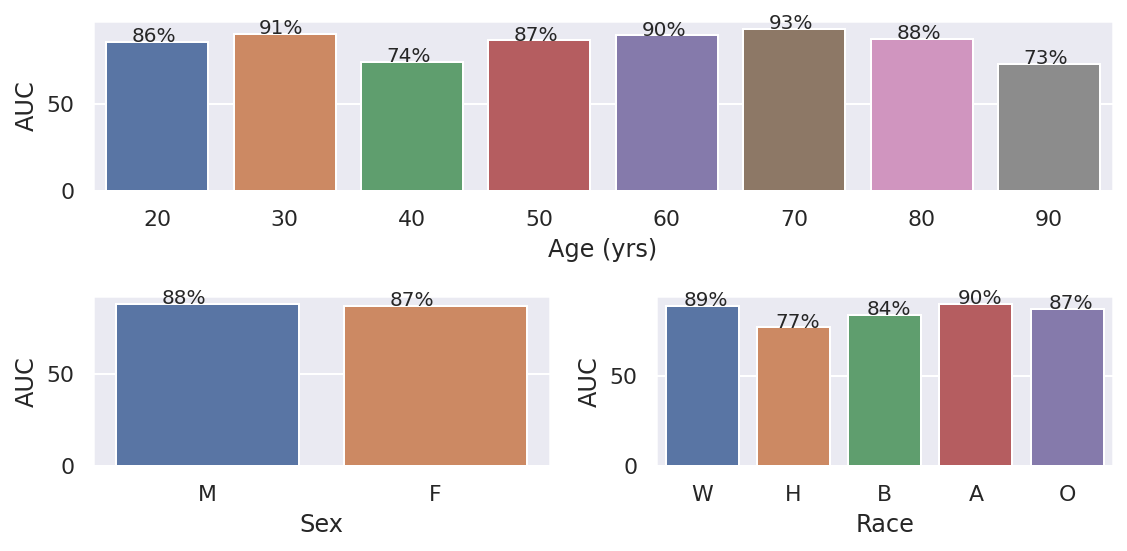

In [159]:
#@title
def plot_auc_by_cat(col, cats):
  vals = df_data[col].value_counts().index
  df_results = pd.DataFrame(columns=[col, 'AUC'])
  for val in vals:
    df = df_data[df_data[col]==val]
    auc = metrics.roc_auc_score(df['y'], df['proba'])
    df_results = df_results.append({col: val, 'AUC':round(100*auc,2)}, ignore_index=True)
  df_results = df_results.set_index(col)
  df_results = df_results.loc[cats]

  ax = sns.barplot(x=df_results.index, y='AUC', data=df_results)
  for p, cnt in zip(ax.patches, df_results['AUC']):
    ax.annotate(f'{cnt:.0f}%', (p.get_x()+0.20, p.get_height()), fontsize=10)  
  return df_results

plt.figure(figsize=(8,4))

plt.subplot(2,1,1)
df_age_auc = plot_auc_by_cat(COL.age, [20, 30, 40, 50, 60, 70, 80, 90])
plt.subplot(2,2,3)
df_sex_auc = plot_auc_by_cat(COL.sex, ['M','F'])
plt.subplot(2,2,4)
df_race_auc = plot_auc_by_cat(COL.race, ['W','H','B','A','O'])

plt.tight_layout()
if LOG_EXPERIMENT:
  exp.log_figure(figure_name='AUC by cohort', figure=plt)
plt.show()

## By cutoff

,Present,Absent
Positive,21,2
Negative,105,1132



Sensitivity: 16.67% [95% CI: 10.62%-24.34%]
Specificity: 99.82% [95% CI: 99.36%-99.98%]
PPV: 91.30% [95% CI: 71.96%-98.93%]
NPV: 91.51% [95% CI: 89.82%-93.01%]



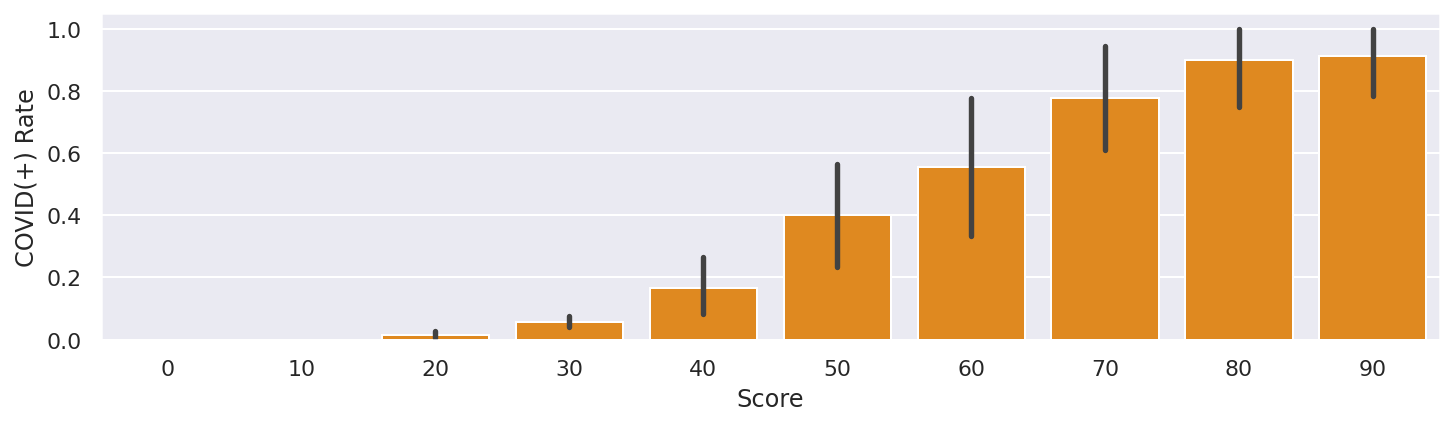

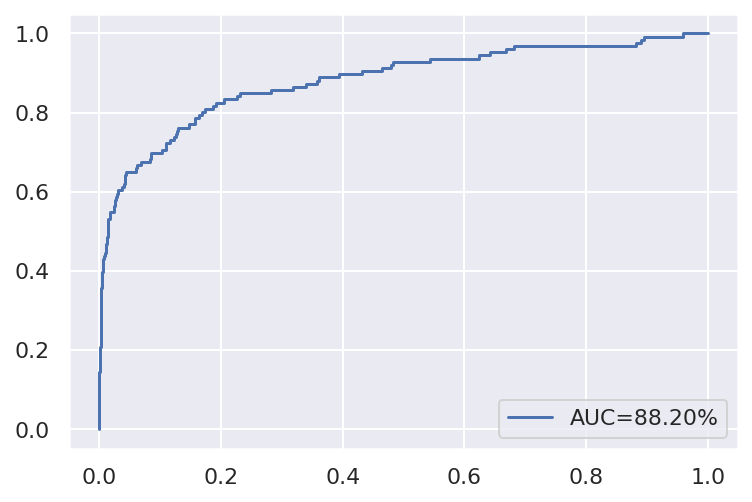

In [140]:
#@title
from statsmodels.stats.proportion import proportion_confint

Score_Cutoff =     90#@param {type:"number"}
Prevalence =     0.1#@param {type:"number"}
Source = "All" #@param ["All", "UVMMC"]

df = df_data[df_data['Source']==Source] if Source!='All' else df_data

# Apply prevalence
n_pos = (df['y']==1).sum()
n_neg = n_pos*(1-Prevalence)/Prevalence
df_neg = df[df['y']==0]
df_pos = df[df['y']==1]

if n_neg<len(df_neg):
  df = pd.concat([df_pos, df_neg.sample(n=int(n_neg))])

  cm = [[((df['y']==1) & (100*df['proba']>=Score_Cutoff)).sum(), ((df['y']==0) & (100*df['proba']>=Score_Cutoff)).sum()],
        [((df['y']==1) & (100*df['proba']<Score_Cutoff)).sum(),  ((df['y']==0) & (100*df['proba']<Score_Cutoff)).sum()]]
  df_cm = pd.DataFrame(cm, index=['Positive','Negative'], columns=['Present','Absent'])
  display(df_cm)

  sens_ci = proportion_confint(df_cm.loc['Positive']['Present'], df_cm['Present'].sum(), method='beta')
  spec_ci = proportion_confint(df_cm.loc['Negative']['Absent'], df_cm['Absent'].sum(), method='beta')
  ppv_ci = proportion_confint(df_cm.loc['Positive']['Present'], df_cm.loc['Positive'].sum(), method='beta')
  npv_ci = proportion_confint(df_cm.loc['Negative']['Absent'], df_cm.loc['Negative'].sum(), method='beta')

  print()
  print(f"Sensitivity: {100*df_cm.loc['Positive']['Present']/df_cm['Present'].sum():.2f}% [95% CI: {100*sens_ci[0]:.2f}%-{100*sens_ci[1]:.2f}%]")
  print(f"Specificity: {100*df_cm.loc['Negative']['Absent']/df_cm['Absent'].sum():.2f}% [95% CI: {100*spec_ci[0]:.2f}%-{100*spec_ci[1]:.2f}%]")
  print(f"PPV: {100*df_cm.loc['Positive']['Present']/df_cm.loc['Positive'].sum():.2f}% [95% CI: {100*ppv_ci[0]:.2f}%-{100*ppv_ci[1]:.2f}%]")
  print(f"NPV: {100*df_cm.loc['Negative']['Absent']/df_cm.loc['Negative'].sum():.2f}% [95% CI: {100*npv_ci[0]:.2f}%-{100*npv_ci[1]:.2f}%]")
  print()

  # Calibration results
  plt.figure(figsize=(12,3))
  s = pd.cut(100*df['proba'], bins=np.linspace(0,100,11)).apply(lambda cat: int(cat.left)).rename('Score')
  sns.barplot(x=s, y=df['y'].rename('COVID(+) Rate'), estimator=np.mean, color='darkorange')
  plt.show()

  fpr, tpr, _ = metrics.roc_curve(df['y'], df['proba'])
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'AUC={100*auc:.2f}%')
  plt.legend(loc='lower right')
  plt.show()
else:
  print('Too few negatives to achieve required prevalence.')

## By source holdout

Holdout: Cedars-Sinai, AUC: 90.16%
Holdout: UVMMC, AUC: 87.5%
Holdout: Maimonides, AUC: 90.93%


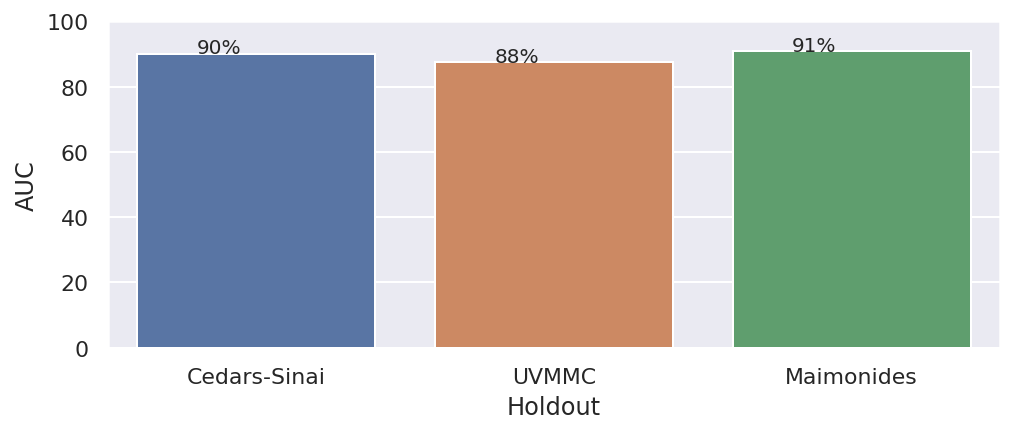

In [141]:
#@title
from sklearn.model_selection import train_test_split

df_results = pd.DataFrame(columns=['Holdout', 'AUC'])

df_ctl = df_data[df_data['y']==0]
df_ctl_train, df_ctl_test = train_test_split(df_ctl, test_size=0.3)
df_pos = df_data[df_data['y']==1]

pos_src = ['Cedars-Sinai', 'UVMMC', 'Maimonides']
for holdout_src in pos_src:
  train_src = list(set(pos_src) - set([holdout_src]))
  test_src = [holdout_src]
  df_pos_train = df_pos[df_pos['Source'].isin(train_src)]
  df_pos_test = df_pos[df_pos['Source'].isin(test_src)]

  df_train = pd.concat([df_ctl_train, df_pos_train])
  df_test = pd.concat([df_ctl_test, df_pos_test])
  X_train, y_train = df_train[CONFIG_FEATS], df_train['y']
  X_test, y_test = df_test[CONFIG_FEATS], df_test['y']
  
  m = CONFIG_MODEL
  m.fit(X_train, y_train)
  y_proba = m.predict_proba(X_test)[:,1]

  auc = round(100*metrics.roc_auc_score(y_test, y_proba), 2)
  df_results = df_results.append({'Holdout': holdout_src, 'AUC':auc}, ignore_index=True)
  print(f'Holdout: {holdout_src}, AUC: {auc}%')

plt.figure(figsize=(8,3))
ax = sns.barplot(x='Holdout', y='AUC', data=df_results)
for p, cnt in zip(ax.patches, df_results['AUC']):
  ax.annotate(f'{cnt:.0f}%', (p.get_x()+0.20, p.get_height()), fontsize=10)  
plt.ylim(0,100)

if LOG_EXPERIMENT:
  exp.log_figure(figure_name='AUC by source holdout', figure=plt)
plt.show()

# Feature analysis

### Top markers performance

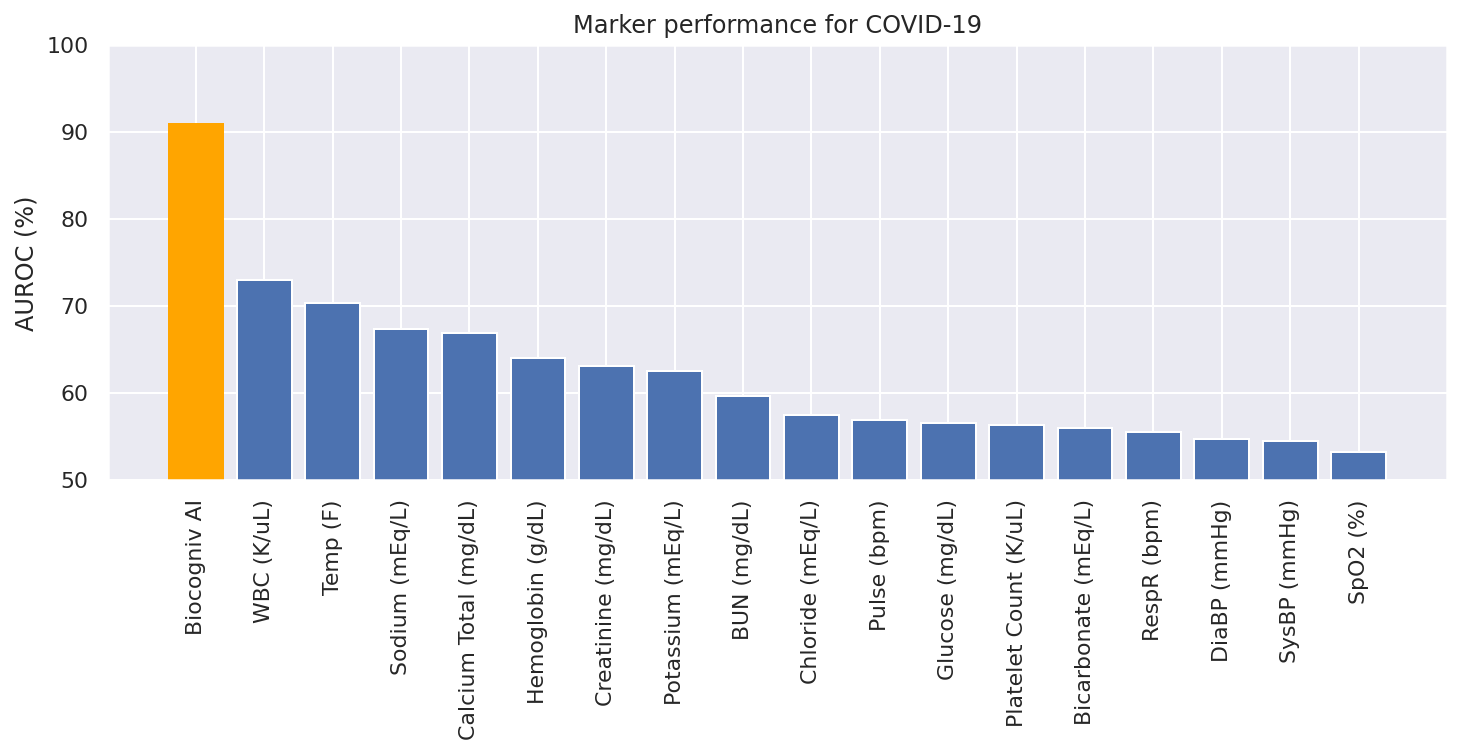

,importance,auc,X_index
feature,,,
WBC (K/uL),1212.00,73.00,6
Temp (F),1053.81,70.32,0
Hemoglobin (g/dL),990.26,64.00,7
Calcium Total (mg/dL),776.98,66.90,16
Platelet Count (K/uL),652.84,56.25,8
Pulse (bpm),616.19,56.85,1
RespR (bpm),611.21,55.51,4
Potassium (mEq/L),585.46,62.50,10
Sodium (mEq/L),559.94,67.36,9


In [142]:
#@title
df = df_top_feats.append(pd.Series({'auc':100*ai_stats['auroc']}).rename(f'{CONFIG_COMPANY} AI'))
df = df.sort_values('auc', ascending=False)
plt.figure(figsize=(12,4))
bars = plt.bar(df.index, df['auc'])
bars[0].set_color('orange')
plt.xticks(rotation=90)
plt.ylim(50,100)
plt.ylabel('AUROC (%)')
plt.title(f'Marker performance for {dx_title}')

plt.show()

display(df_top_feats)

### Features - Histograms

<IPython.core.display.Javascript object>

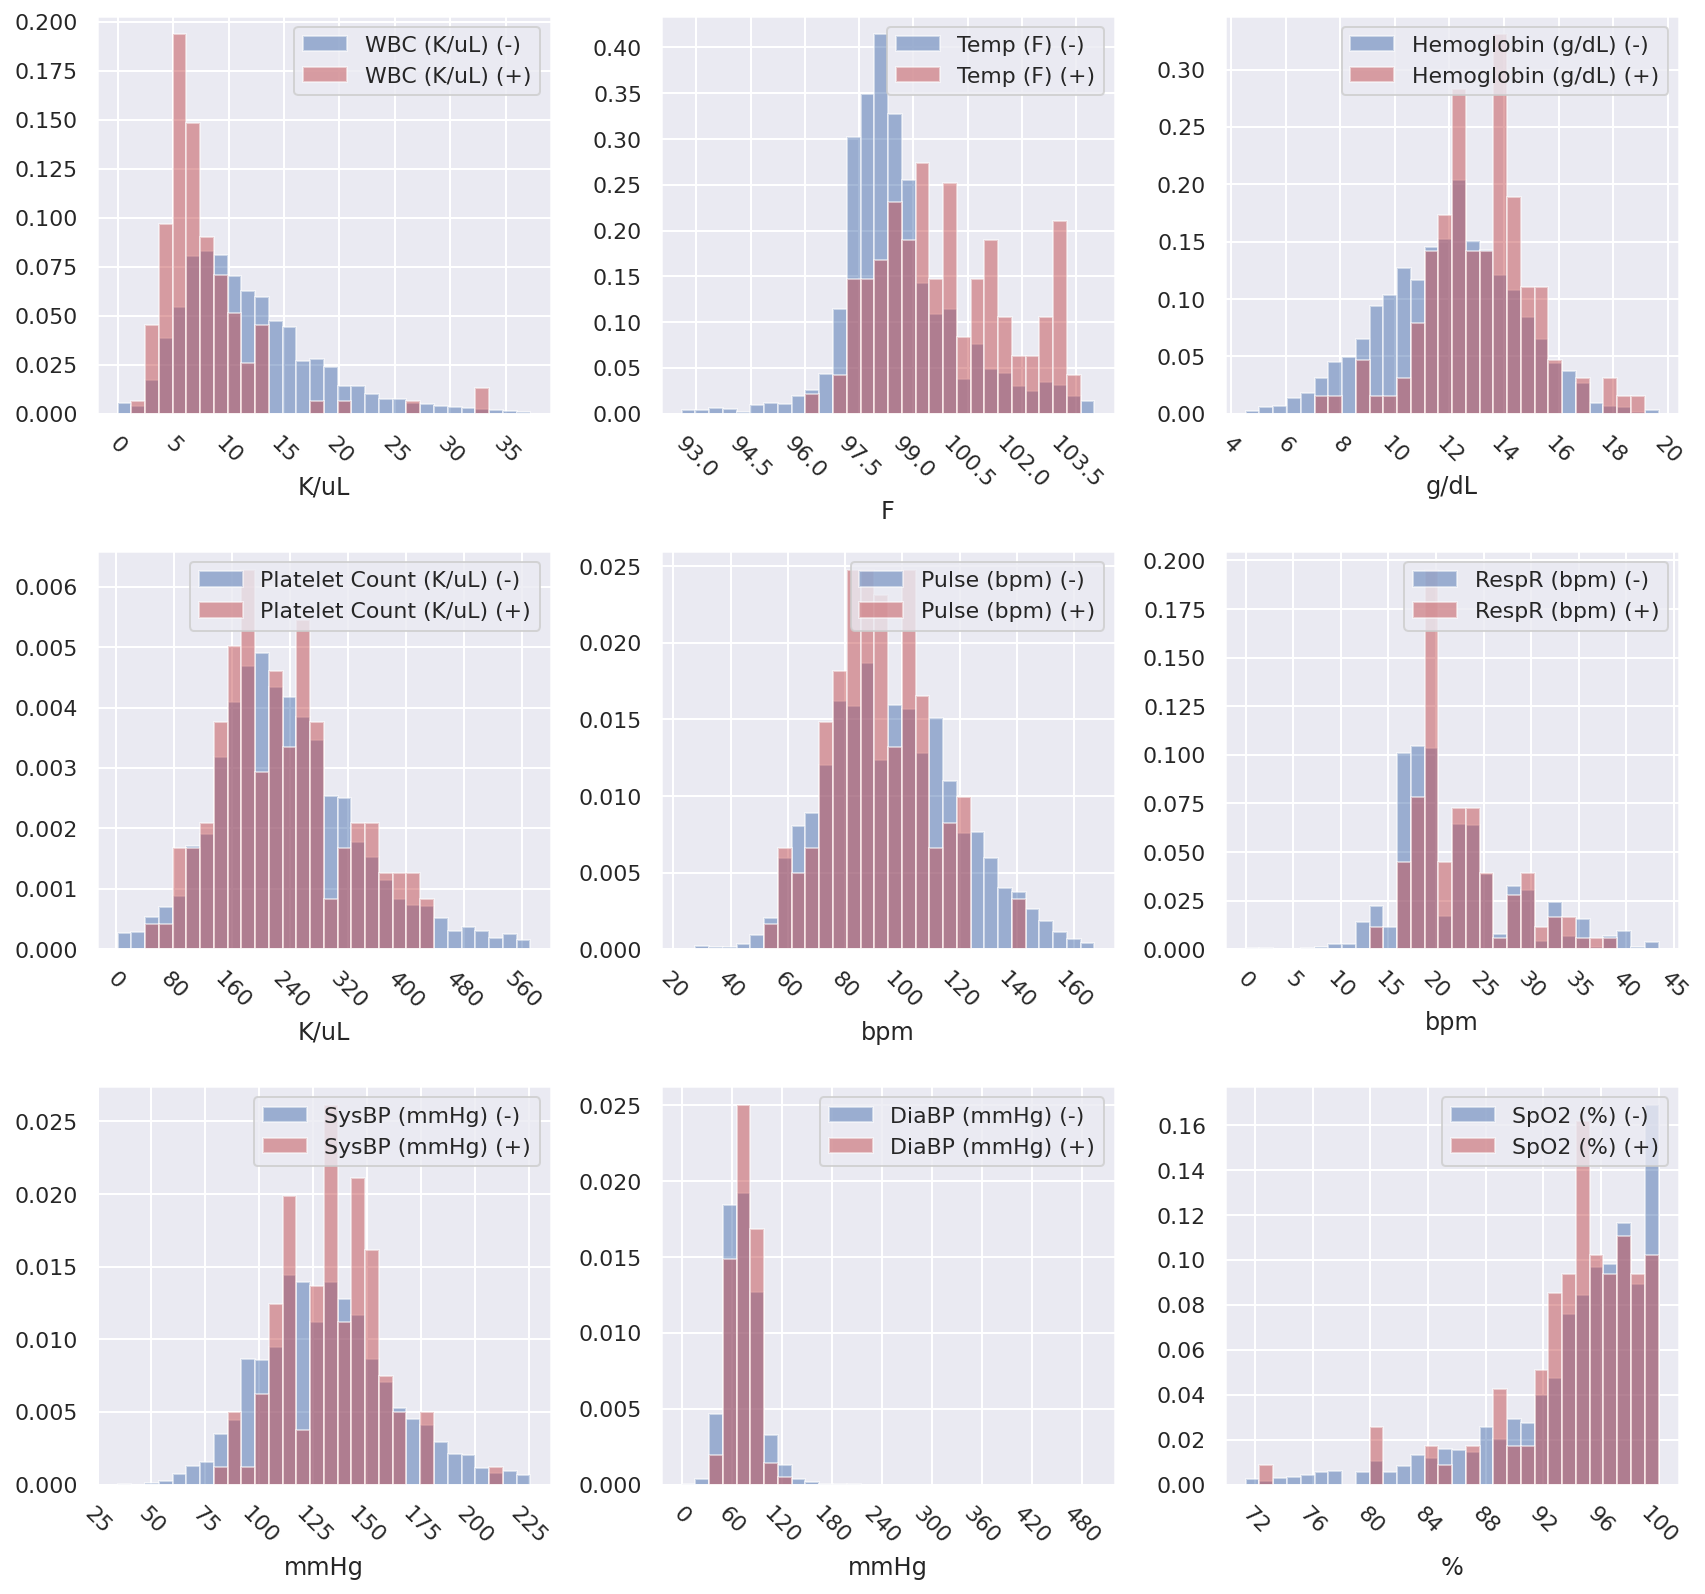

In [143]:
#@title
import matplotlib.ticker as plticker

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

df = df_data
df_feats = df_top_feats.loc[df_data[CONFIG_FEATS].select_dtypes(include=['float64']).columns]
cols = df_feats[:9].sort_values(by='importance', ascending=False).index
NCOLS = min(3, len(cols))
fig, axes = plt.subplots(nrows=math.ceil(len(cols)/NCOLS), ncols=NCOLS, figsize=(min(12, len(cols)*2.5), 1.25*len(cols)))

for idx, feat in enumerate(cols): 

    units = get_units(feat)
    xmin = df[feat].min()
    xmax = df[feat].max()
    xmed = df[feat].median()
    xstd = df[feat].std()
    rng = (max(xmin, xmed-3*xstd), min(xmax, xmed+3*xstd))
    ax = axes[int(idx / NCOLS), idx % NCOLS] if len(cols)>1 else axes
    plt.sca(ax)
    plt.hist(df[df['y']==0][feat], 30, range=rng, alpha=0.5, label=f"{feat} (-)", color='b', density=True)
    plt.hist(df[df['y']==1][feat], 30, range=rng, alpha=0.5, label=f"{feat} (+)", color='r', density=True)
    plt.xlabel(units)
    plt.xticks(rotation=-45)
    ax.xaxis.set_major_locator(plticker.MaxNLocator(min_n_ticks=5))
    plt.legend(loc='upper right')
fig.tight_layout();

### Features - Box plots

<IPython.core.display.Javascript object>

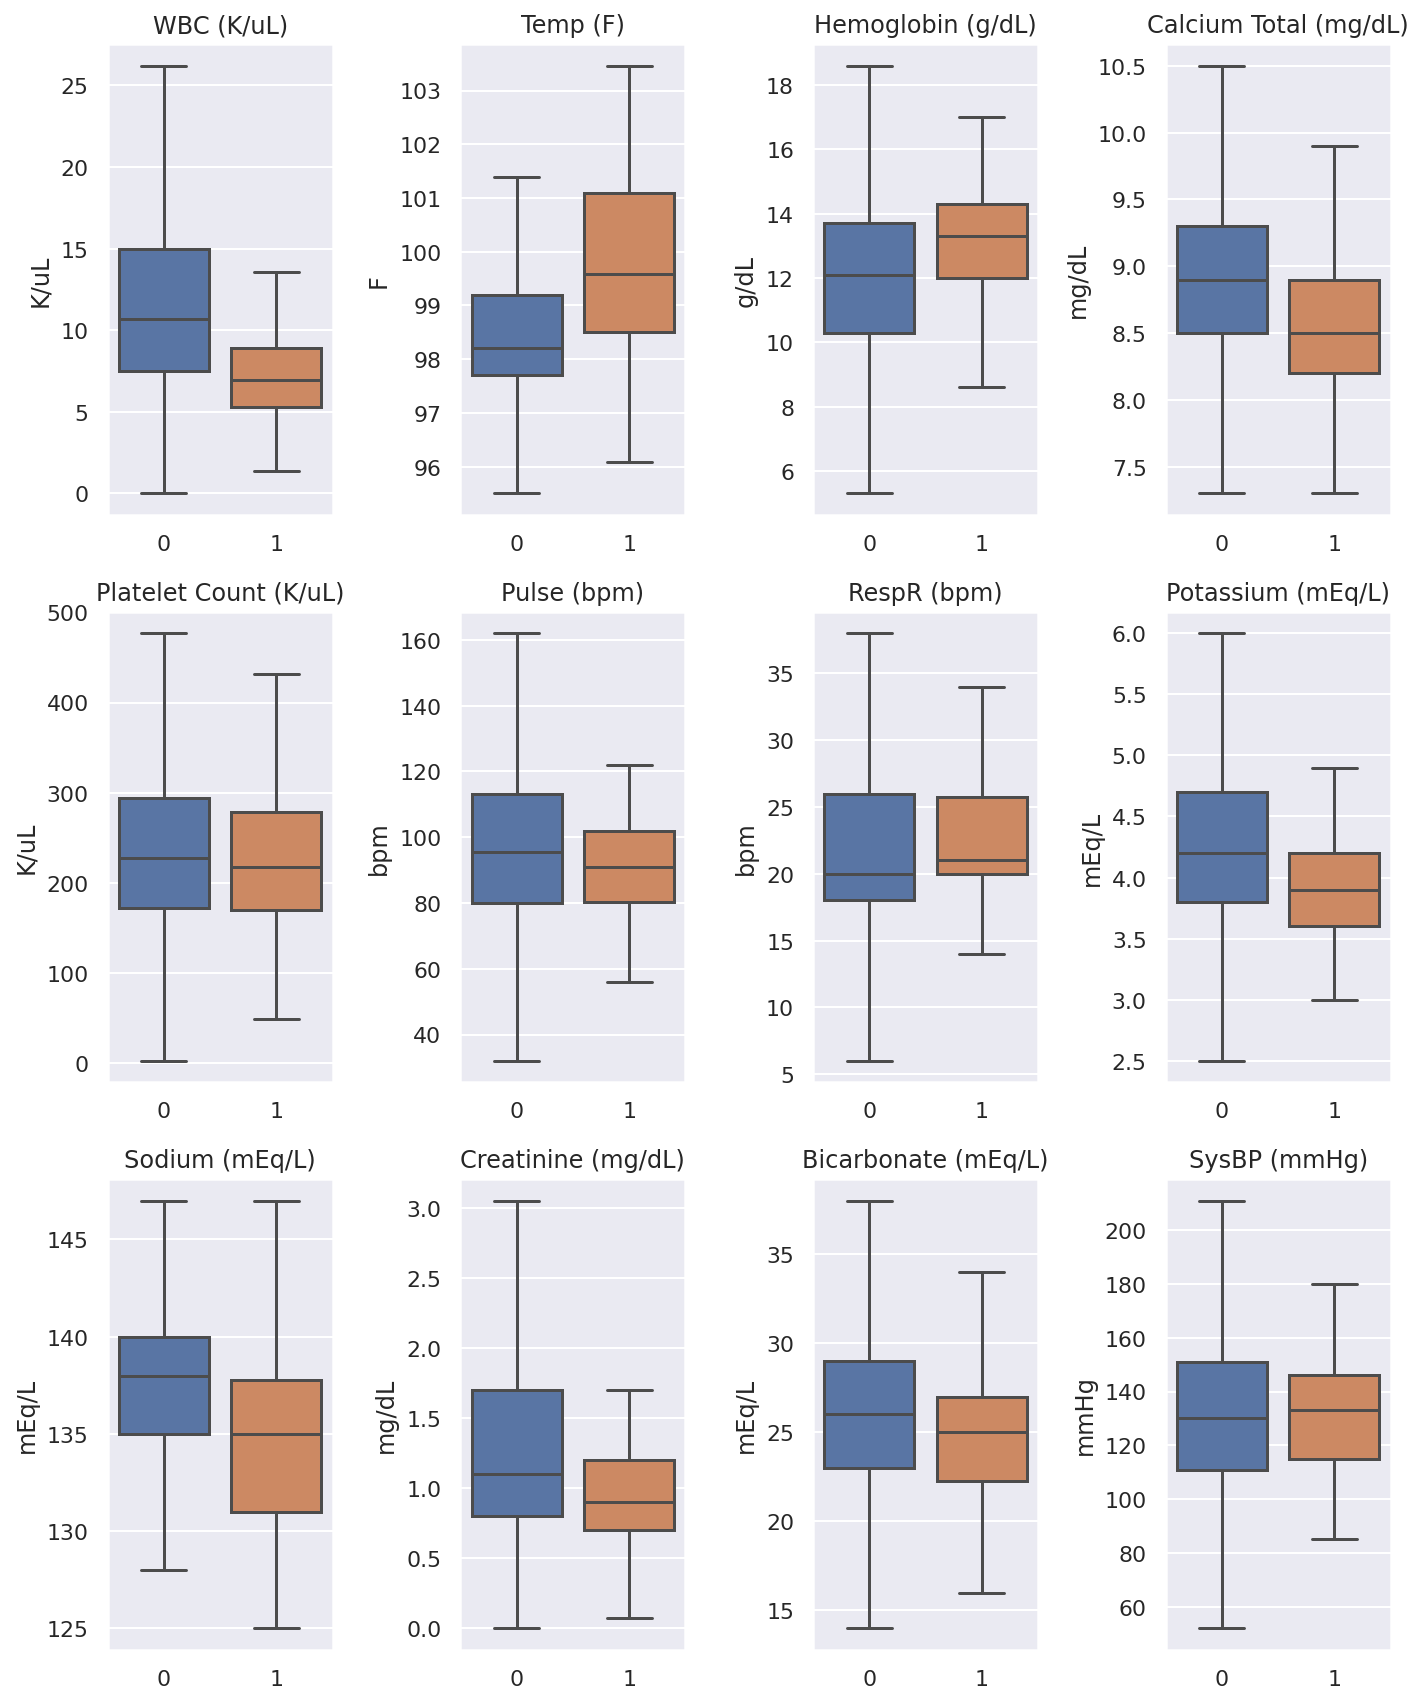

In [144]:
#@title
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

# # From https://cllsociety.org/toolbox/normal-lab-values/
# limits = {
#   # Vitals
#    "Temp (F)": [97.8, 99]
#   ,"Pulse (bpm)": [60, 100]
#   ,"SysBP (mmHg)": [90, 120]
#   ,"DiaBP (mmHg)": [60, 80]
#   ,"RespR (/min)": [12, 16]
#   ,"SpO2 (%)": [95, 100]
#   # CBC
#   ,"White Blood Cells (K/uL)": [3.5, 10.5]
#   ,"Red Blood Cells (m/uL)": [4.2, 6.1]
#   ,"Hemoglobin (g/dL)": [12.1, 17.2]
#   ,"Hematocrit (%)": [36.1, 50.3]
#   ,"MCV (fL)": [80, 100]
#   ,"MCH (pg)": [27, 31]
#   ,"MCHC (g/dL)": [32, 36]
#   ,"RDW (%)": [11.8, 15.6]
#   ,"Platelet Count (K/uL)": [150, 450]
#   ,"Eosinophils (%)": [1, 4]
#   ,"Lymphocytes (%)": [20, 40]
#   ,"Monocytes (%)": [2, 8]
#   ,"Neutrophils (%)": [40, 70]
#   ,"Basophils (%)": [0.5, 1]
#   # BMP
#   ,"Urea Nitrogen (mg/dL)": [6, 20]
#   ,"Creatinine (mg/dL)": [1, 2]
#   ,"Glucose (mg/dL)": [80, 120]
#   ,"Potassium (mEq/L)": [3.5, 5.5]
#   ,"Sodium (mEq/L)": [135, 147]
#   ,"Bicarbonate (mEq/L)": [23, 29]
#   ,"Chloride (mEq/L)": [98, 106]
#   ,"Calcium, Total (mg/dL)": [8.5, 10.2]
# }

cols = df_top_feats[:12].sort_values(by='importance', ascending=False).index
NCOLS = min(4, len(cols))
fig, axes = plt.subplots(nrows=math.ceil(len(cols)/NCOLS), ncols=NCOLS, figsize=(min(10, len(cols)*2.5), len(cols)))

for idx, feat in enumerate(cols): 
    units = get_units(feat)
    ax = axes[int(idx / NCOLS), idx % NCOLS] if len(cols)>NCOLS else axes
    # ax.set_yscale('log')
    sns.boxplot(x='y', y=feat, data=df_data, ax=ax, showfliers=False)
    # ax.plot([-0.5, 1.5], [limits[feat][0]]*2, '--', linewidth=2, color='b')
    # ax.plot([-0.5, 1.5], [limits[feat][1]]*2, '--', linewidth=2, color='b')
    ax.set_xlabel('') 
    ax.set_ylabel(units) 
    ax.set_title(feat)  
fig.tight_layout()

### Parallel coordinates

In [0]:
# #@title
# df_pos = df_data[df_data['y']==1][CONFIG_FEATS + ['y']]
# df_neg = df_data[df_data['y']==0][CONFIG_FEATS + ['y']]
# df = pd.concat([df_neg.sample(n=len(df_pos)), df_pos])
# df = ((df[CONFIG_FEATS]-df[CONFIG_FEATS].mean())/df[CONFIG_FEATS].std()).join(df['y'])

# cols = df_top_feats.sort_values(by='importance', ascending=False).index
# pal = sns.color_palette()

# plt.figure(figsize=(12,8))
# pd.plotting.parallel_coordinates(df, class_column='y', cols=cols, color=(pal[0], pal[1]), alpha=0.5)
# plt.xticks(rotation=90)
# plt.ylim(-5,5)
# plt.show()

# Manual extracts

In [146]:
df = df_data.copy()
df['Score'] = (100*df['proba']).round(2)
df['SIRS'] = get_sirs_score(df)
df[df['y']==1][['Source', 'covid', 'Score', 'SIRS', 'icuadmit', 'hospdeath', 'days_symptoms', 'notes']]

,Source,covid,Score,SIRS,icuadmit,hospdeath,days_symptoms,notes
visit_id,,,,,,,,
UVMMC:22,UVMMC,1,32.85,2,0,0,1,direct admit
UVMMC:32,UVMMC,1,31.49,1,0,0,1,known positive on arrival
UVMMC:45,UVMMC,1,66.97,0,0,0,1,Discharged to home/self care
UVMMC:49,UVMMC,1,29.11,2,0,1,1,patient died 3 days into admit
UVMMC:5,UVMMC,1,86.58,1,0,0,4,Still inpatient (developed delirium from hospi...
...,...,...,...,...,...,...,...,...
Maimonides:MM013,Maimonides,1,34.46,1,1,1,7.0,NaN
Maimonides:MM014,Maimonides,1,89.92,3,1,1,5.0,NaN
Maimonides:MM009,Maimonides,1,77.64,3,1,1,7.0,NaN


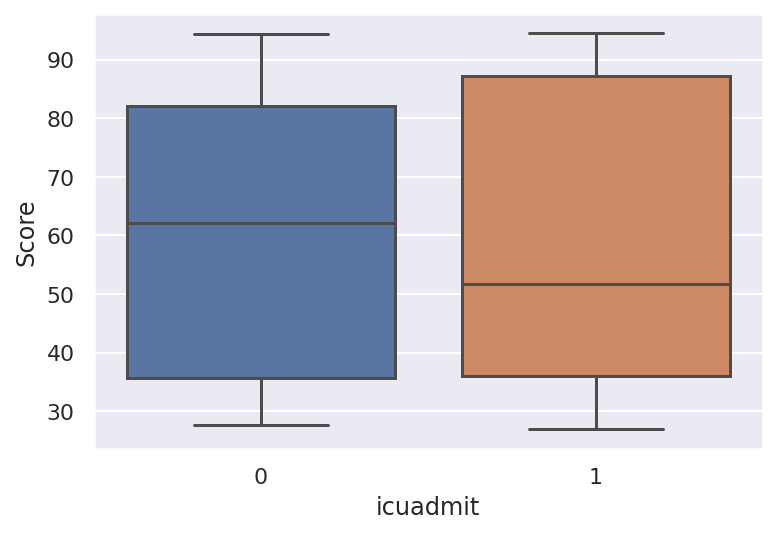

In [147]:
sns.boxplot(x='icuadmit', y='Score', data=df[df['y']==1])

In [148]:
df = df_data.copy()
df['Score'] = (100*df['proba']).round(2)
df['SIRS'] = get_sirs_score(df)
df[df['y']==0][['Source', 'covid', 'Score', 'SIRS', 'icuadmit', 'hospdeath', 'days_symptoms', 'notes']].sample(n=25)

,Source,covid,Score,SIRS,icuadmit,hospdeath,days_symptoms,notes
visit_id,,,,,,,,
eICU:162223,eICU,0,33.54,0,1,0,NaN,NaN
BIDMC:35270941,BIDMC,0,45.27,0,0,0,NaN,NaN
eICU:181537,eICU,0,34.08,1,1,0,NaN,NaN
eICU:2453360,eICU,0,36.65,3,1,0,NaN,NaN
BIDMC:39966775,BIDMC,0,32.97,0,0,0,NaN,NaN
BIDMC:36993632,BIDMC,0,28.68,1,0,0,NaN,NaN
BIDMC:34084228,BIDMC,0,33.37,1,0,0,NaN,NaN
BIDMC:32063954,BIDMC,0,32.74,1,1,0,NaN,NaN
eICU:236820,eICU,0,28.50,0,1,0,NaN,NaN


# File extracts

In [0]:
# df = pd.DataFrame(X, columns=CONFIG_FEATS)
# df = df.join(pd.Series(y).rename('y'))
# df_neg = df[df['y']==0].sample(n=10)
# df_pos = df[df['y']==1].sample(n=10)
# df = pd.concat([df_neg, df_pos])
# df.to_csv('X_y.csv', index=False)

In [0]:
# m = CONFIG_MODEL
# m.fit(X, y)
# m.save_model('model.bst')

# Wrap up experiment

In [0]:
if LOG_EXPERIMENT:
  exp.log_metric('auc', round(100*ai_stats['auroc'],2))
  exp.log_metric('auc0', round(100*ai_stats['auroc0'],2))
  exp.log_metric('auc_age_min', df_age_auc['AUC'].min())
  exp.log_metric('auc_sex_min', df_sex_auc['AUC'].min())
  exp.log_metric('auc_race_min', df_race_auc['AUC'].min())
  exp.log_metric('n', len(df_data))
  exp.log_metric('n_neg', (df_data['y']==0).sum())
  exp.log_metric('n_pos', (df_data['y']==1).sum())
  exp.log_metric('n_feats', len(CONFIG_FEATS))
  exp.log_metric('n_sources', len(np.unique(df_data['Source'])))
  exp.log_metric('n_imputed', len(CONFIG_FEATS)-len(CONFIG_FEATS_MANDATORY))
  
  exp.log_other('model', CONFIG_MODEL.__class__.__name__)
  exp.log_other('vitals', 'y' if set(VITALS).intersection(set(CONFIG_FEATS)) else 'n')
  exp.log_other('demo', 'y' if set(DEMO).intersection(set(CONFIG_FEATS)) else 'n')
  exp.log_other('calibrate', 'n' if CONFIG_CALIBRATE==None else 'y')
  exp.log_other('demo_reweight', 'n' if CONFIG_DEMO_REWEIGHT==None else 'y')
  exp.log_other('K', CONFIG_K)

  exp.end()
  
  LOG_EXPERIMENT = False # require a kernel restart to log experiment again